### Introduction

This notebook shows how to scrape shot data from the [EIHL](www.eliteleague.co.uk) website, perform analysis on the data and build shot quality models using Logistic Regression and a Random Forest. 

Before running this notebook you will have to run the ```GetPenaltiesAndGoals.ipynb``` notebook first to get the penalty and goal data that will be required. You will also need the ```shotplots.py``` file which contains functions to plot some of the shot data.

The accompanying blog post can be found [here](www.ncalvert.uk/posts/eihlshots/).

First, let's import the libraries we'll need.

In [1]:
import datetime as dt
import importlib
import json
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import numpy as np
from os import listdir
from os.path import isfile, join
from os import walk
import pandas as pd
import re
import requests
from scipy import stats
import shotplots as sp
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import time
%matplotlib inline
importlib.reload(sp)
pd.options.display.max_columns = None

### Get the Shot Data

I scraped the raw shot data from the EIHL website, first I got the fixture list then I found the numeric ID of each match and got the raw data from the Amazon Web Server site. Initially I saved this to file, to avoid having to re-scrape the data, however I am not sharing the raw data here. The ```base_image_nc.png``` image is a sketch of an ice rink that I made in Inkscape. I used the dimensons from the IIHF to ensure the layout was correct.

The data comes in JSON format which is then converted to a Pandas DataFrame. I've put a 10 second pause in between each access of the website to ensure that I do not send to many calls.

In [2]:
pre_scraped = True
base_image = plt.imread("base_image_nc.png")

In [3]:
all_shots = []
if pre_scraped:
    shotspath = "./ShotMaps/"
    for (dirpath, dirnames, filenames) in walk(shotspath):
        for fname in filenames:
            with open(shotspath+fname) as f:
                if fname[-4:] =="json":
                    shots = json.load(f)
                    home_id = shots['match']['home_id']
                    home_name = shots['match']['home_name']
                    visitor_id = shots['match']['visitor_id']
                    visitor_name = shots['match']['visitor_name']
                    s_id = int(fname.strip(".json"))
                    for s in shots['match']['shots']:
                        s1 = s
                        if s1['team_id'] == home_id:
                            s1['home_game'] = True
                            s1['team_name'] = home_name
                            s1['opposition_id'] = visitor_id
                            s1['opposition_name'] = visitor_name
                            s1['match_id'] = s_id
                        else:
                            s1['home_game'] = False
                            s1['team_name'] = visitor_name
                            s1['opposition_id'] = home_id
                            s1['opposition_name'] = home_name
                            s1['match_id'] = s_id
                        all_shots.append(s1)
else:
    fixtures_url = "https://www.eliteleague.co.uk/schedule?id_season=2&id_team=0&id_month=999"
    fixtures_html = requests.get(fixtures_url)
    idxs = [m.start() for m in re.finditer("a href=\"/game/", fixtures_html.text)]
    game_ids = []
    for ind in idxs:
        ind1 = fixtures_html.text.find(" class",ind)
        g_id = fixtures_html.text[ind+8:ind1-1]
        track_url = "https://www.eliteleague.co.uk" +g_id + "/tracking"
        track_html = requests.get(track_url)
        ind2 = track_html.text.find("https://eihl.hokejovyzapis.cz/visualization/")
        ind3 = track_html.text.find("\"",ind2)
        s_id = track_html.text[(ind3-4):ind3]
        if(s_id[0] == "="):
            s_id = s_id[1:]
        if s_id not in game_ids:
            game_ids.append(int(s_id))
            json_url = "https://s3-eu-west-1.amazonaws.com/eihl.hokejovyzapis.cz/visualization/shots/" + str(s_id) + ".json"
            shots = requests.get(json_url).text
            home_id = shots['match']['home_id']
            home_name = shots['match']['home_name']
            visitor_id = shots['match']['visitor_id']
            visitor_name = shots['match']['visitor_name']
            for s in shots['match']['shots']:
                s1 = s
                if s1['team_id'] == home_id:
                    s1['home_game'] = True
                    s1['team_name'] = home_name
                    s1['opposition_id'] = visitor_id
                    s1['opposition_name'] = visitor_name
                    s1['match_id'] = s_id
                else:
                    s1['home_game'] = False
                    s1['team_name'] = visitor_name
                    s1['opposition_id'] = home_id
                    s1['opposition_name'] = home_name
                    s1['match_id'] = s_id
                all_shots.append(s1)
        time.sleep(10)

### Process the raw data
Now we have the raw data we can process it and add in some extra information. For example the shot outcomes ranged from 1 - 4, so let's replace those with a text outcome (saved, wide, blocked, goal). I also convert the date into a date formatted variable and extract the year, month, and day. A new ```fullname``` variable is generated which combines the first and last names, and the period that each shot occurs in is also calculated.

The position of the goal is also calculated (from the IIHF dimensions) and a shot distance is calculated, although this will be improved on shortly to account for the different sizes of the rinks. The coordinates of the shots are corrected - in the original data the home and away team were shooting at different ends of the ice but I have corrected this to make the analysis easier.

In [4]:
all_shot_df = pd.DataFrame(all_shots)
#1 = saved
#2 = wide
#3 = blocked
#4 = goal
all_shot_df.loc[:,"shot_outcome"] = ""
all_shot_df.loc[all_shot_df.loc[:,"match_shot_resutl_id"]==1,"shot_outcome"] = "saved"
all_shot_df.loc[all_shot_df.loc[:,"match_shot_resutl_id"]==2,"shot_outcome"] = "wide"
all_shot_df.loc[all_shot_df.loc[:,"match_shot_resutl_id"]==3,"shot_outcome"] = "blocked"
all_shot_df.loc[all_shot_df.loc[:,"match_shot_resutl_id"]==4,"shot_outcome"] = "goal"
all_shot_df.loc[:,"real_date"] = pd.to_datetime(all_shot_df.loc[:,"real_date"])
all_shot_df.loc[:,"year"] = all_shot_df.loc[:,"real_date"].apply(lambda x:  x.year)
all_shot_df.loc[:,"month"] = all_shot_df.loc[:,"real_date"].apply(lambda x:  x.month)
all_shot_df.loc[:,"day"] = all_shot_df.loc[:,"real_date"].apply(lambda x:  x.day)
all_shot_df.loc[:,"fullname"] = all_shot_df.loc[:,"first_name"]+all_shot_df.loc[:,"last_name"]
all_shot_df.loc[:,"fullname"] = all_shot_df.loc[:,"fullname"].str.replace(" ","")
all_shot_df.loc[:,"period"] = 4
all_shot_df.loc[(all_shot_df.loc[:,"time"]>=0) & (all_shot_df.loc[:,"time"]<= 60*20),"period"] = 1
all_shot_df.loc[(all_shot_df.loc[:,"time"]>=60*20) & (all_shot_df.loc[:,"time"]<= 60*40),"period"] = 2
all_shot_df.loc[(all_shot_df.loc[:,"time"]>=60*40) & (all_shot_df.loc[:,"time"]<= 60*60),"period"] = 3
# Set the position of the centre of the goal
goalx = 0.
goaly = 100*(1-4/30)
all_shot_df.loc[:,"shotdistance"] = 0.
h_inds = all_shot_df.loc[:,"home_game"] == True
a_inds = all_shot_df.loc[:,"home_game"] == False
all_shot_df.loc[h_inds,"shotdistance"] = np.sqrt(
    np.power(-0.5*all_shot_df.loc[h_inds,"coordinate_y"] - goalx,2)+
    np.power(all_shot_df.loc[h_inds,"coordinate_x"]-goaly,2)
)
all_shot_df.loc[a_inds,"shotdistance"] = np.sqrt(
    np.power(0.5*all_shot_df.loc[a_inds,"coordinate_y"] - goalx,2)+
    np.power(-all_shot_df.loc[a_inds,"coordinate_x"]-goaly,2)
)
all_shot_df.loc[:,"goal"] = all_shot_df.loc[:,"shot_outcome"] =="goal"
all_shot_df = all_shot_df.sort_values(by = ["match_id","team_id","time"])
all_shot_df.loc[:,"corrected_x"] = all_shot_df.loc[:,"coordinate_x"]
all_shot_df.loc[:,"corrected_y"] = all_shot_df.loc[:,"coordinate_y"]

all_shot_df.loc[all_shot_df.loc[:,"home_game"]==False,"corrected_x"] = -all_shot_df.loc[:,"coordinate_x"]
all_shot_df.loc[all_shot_df.loc[:,"home_game"]==False,"corrected_y"] = -all_shot_df.loc[:,"coordinate_y"]



We then get the length of the match, which is usually 60 minutes but can be longer if the game goes to overtime (maximum 65 minutes in total). A goal in overtime stops the game short of 65 minutes.

In [5]:
all_shot_df.loc[:,"match_length"] = 60*60
for m in np.unique(all_shot_df.loc[:,"match_id"].values):
    if np.max(all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"period"]) >3:
        t = np.max(all_shot_df.loc[(all_shot_df.loc[:,"match_id"]==m)&(all_shot_df.loc[:,"match_shot_resutl_id"]==4),"time"])
        if t > 60.*60.:
            all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"match_length"] = t
        else:
            all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"match_length"] = 60*65

7 of the rinks used in the EIHL are the standard Olympic Size rink 60 m x 30 m, however 3 are not. We convert the coordinates of each shot to metres from the centre face off dot. I also calculate the position of the centre of the goal in metres for each rink, and calculate the distance of each shot in metres. I also calculate the angle of the shot from the centre of the goal.

In [6]:
# All rinks are olympic, except: Coventry (28 x 56 m), Fife (28.956 x 59.436 m), Manchester (27 x 56 m)
rinkwidths = [30,30,28,30,28.956,30,30,27,30,30]
rinklengths = [60,60,56,60,59.436,60,60,56,60,60]
teams = np.sort(all_shot_df.loc[:,"team_name"].unique())
for i in range(0,len(teams)):
    inds = (all_shot_df.loc[:,"team_name"]==teams[i])&(all_shot_df.loc[:,"home_game"]==True)
    inds1 = (all_shot_df.loc[:,"opposition_name"]==teams[i])&(all_shot_df.loc[:,"home_game"]==False)
    all_shot_df.loc[inds,"rink_w"] = rinkwidths[i]
    all_shot_df.loc[inds1,"rink_w"] = rinkwidths[i]
    all_shot_df.loc[inds,"rink_l"] = rinklengths[i]
    all_shot_df.loc[inds1,"rink_l"] = rinklengths[i]
    all_shot_df.loc[inds1,"rink"] = teams[i]
    all_shot_df.loc[inds,"rink"] = teams[i]
    all_shot_df.loc[inds,"x_m"] = all_shot_df.loc[inds,"corrected_x"]*rinklengths[i]/200.
    all_shot_df.loc[inds1,"x_m"] = all_shot_df.loc[inds1,"corrected_x"]*rinklengths[i]/200.
    all_shot_df.loc[inds,"y_m"] = all_shot_df.loc[inds,"corrected_y"]*rinkwidths[i]/200.
    all_shot_df.loc[inds1,"y_m"] = all_shot_df.loc[inds1,"corrected_y"]*rinkwidths[i]/200.
    all_shot_df.loc[inds,"goal_x_m"] = goaly*rinklengths[i]/200.
    all_shot_df.loc[inds1,"goal_x_m"] = goaly*rinklengths[i]/200.
    all_shot_df.loc[inds,"goal_y_m"] = goalx*rinkwidths[i]/200.
    all_shot_df.loc[inds1,"goal_y_m"] = goalx*rinkwidths[i]/200.
all_shot_df.loc[:,"shotdistance_m"] = np.sqrt(
    np.power(all_shot_df.loc[:,"x_m"] - all_shot_df.loc[:,"goal_x_m"],2)+
    np.power(all_shot_df.loc[:,"y_m"] - all_shot_df.loc[:,"goal_y_m"],2)
)


In [7]:
all_shot_df.loc[:,"shotangle_deg"] = np.arctan2(all_shot_df.loc[:,"y_m"] - all_shot_df.loc[:,"goal_y_m"],-(all_shot_df.loc[:,"x_m"] - all_shot_df.loc[:,"goal_x_m"]))*180./np.pi

### Correct some of the shots

Some matches had too many goals in the shot data when compared to the goal data. I decided to remove these shots from the database, rather than trying to alter them to saved/blocked/missed. In total there were 11 shots like this.

There were also 5 shots that needed to be changed to goals to match up with the goal data as well.

In [8]:
# Match ID = 1028 has 1 too many goals, and also shows no shots in the third period.
# Some shots are out by 20 minutes but I am not able to figure out which ones.
# We will remove the incorrect goal completely, rather than set to saved/blocked/missed.
# There are other match ids where this is also the case:
#  949.  992. 1012. 1028. 1068. 1111. 1122. 1138. 1173. 2337. 1027.
indicestodrop = [1827,1990,19585,4890,11940,22324,8885,8886,24502]

# Some shots need to be changed to goals
indtogoal = [3090,3107,20904,15901,24501]

In [9]:
all_shot_df.drop(indicestodrop, axis=0,inplace=True)
all_shot_df.loc[indtogoal,"goal"] = True
all_shot_df.loc[indtogoal,"match_shot_resutl_id"] = 4
all_shot_df.loc[indtogoal,"shot_outcome"] = "goal"

### Calculate which shots are rebounds

We can estimate whether a shot is a rebound by looking at the time difference between the shot and the previous saved shot. I also considered looking at blocked and missed shots as rebounds but I ended up going for saved shots to keep in line with previous analyses.

I used 2 seconds as the cut off as the probability of scoring dropped at this limit, and I did not impose a shot distance limit as others have.

In [10]:
timediff=[]
goaltdiff =[]
all_shot_df.loc[:,"time_to_prior_save"] = np.nan
for m in np.unique(all_shot_df.loc[:,"match_id"].values):
    df_temp = all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,:]
    goal = df_temp.loc[:,"goal"].values
    shottimes = df_temp.loc[:,"time"].values
    #df_temp = df_temp.sort_values(by = "time")
    timeofsaves = df_temp.loc[:,"time"].copy()
    timeofsaves.loc[(df_temp.loc[:,"shot_outcome"]!="saved")] = np.nan
    for i in range(0,df_temp.shape[0]):
        timeofshot = df_temp.iloc[i,df_temp.columns.get_loc("time")]
        timessincesave = timeofshot - timeofsaves.values[0:i]
        timessincesave = timessincesave[timessincesave>= 0]
        if len(timessincesave>0):
            timesincesave = np.min(timessincesave)
            if timesincesave>=0:
                df_temp.iloc[i,df_temp.columns.get_loc("time_to_prior_save")] = timesincesave
    tdiffs = shottimes[1:] - shottimes[0:-1]
    ttonext = np.append(tdiffs,np.nan)
    ttonext[ttonext<0] = np.nan
    all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"time_to_next_shot"] = ttonext
    ttolast = np.append(np.nan,tdiffs)
    ttolast[ttolast<0] = np.nan
    all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"time_to_prior_shot"] = ttolast
    timediff = np.append(timediff,tdiffs)
    goaltdiff = np.append(goaltdiff,tdiffs[goal[1:]==True])
    all_shot_df.loc[all_shot_df.loc[:,"match_id"]==m,"time_to_prior_save"] = df_temp.loc[:,"time_to_prior_save"].copy()

# The time limit to use to classify a rebound, we'll use 2 seconds as a default.
# If t < reboundlimit then the shot is a rebound
reboundlimit = 2
all_shot_df.loc[:,"leads_to_rebound"] = False
all_shot_df.loc[:,"is_rebound"] = False
all_shot_df.loc[:,"is_saved_rebound"] = False
#rebounddistlimit = 7.62 # 25 feet as per nhl analysis http://hockeyanalytics.com/Research_files/Shot_Quality.pdf
all_shot_df.loc[all_shot_df.loc[:,"time_to_next_shot"]<(reboundlimit),"leads_to_rebound"] = True
all_shot_df.loc[all_shot_df.loc[:,"time_to_prior_shot"]<(reboundlimit),"is_rebound"] = True
all_shot_df.loc[all_shot_df.loc[:,"time_to_prior_save"]<(reboundlimit),"is_saved_rebound"] = True
#all_shot_df.loc[all_shot_df.loc[:,"shotdistance_m"]>(rebounddistlimit),"is_saved_rebound"] = False

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


### Load in the Goal & Penalty Data

We previously scraped the penalty and goal data in the other notebook (GetPenaltiesAndGoals.ipynb), so we can load that in here.

A few games that went to Penalty shots had an extra goal in the gamesheet to signify who scored the winning penalty shot, so I dropped those goals from the DataFrame.

I then calculate the number of players on the ice at each time during the game, which will be used later on when analysing the shot data.

In [11]:
allpendf = pd.read_pickle("./AllPenalties.pkl")
allgoaldf = pd.read_pickle("./AllGoals.pkl")
nongoals = (allgoaldf.loc[:,"Goal_sec"]==3900)&(allgoaldf.loc[:,"GS"]=="PS")
allgoaldf = allgoaldf.loc[~nongoals,:]
t = np.arange(0,65*60+1,1)
hps = np.zeros([len(t),allpendf.loc[:,"Match_ID"].nunique()])
aps = np.zeros([len(t),allpendf.loc[:,"Match_ID"].nunique()])
m_ids = []
for idx in range(0,allpendf.loc[:,"Match_ID"].nunique()):
    m_id = allpendf.loc[:,"Match_ID"].unique()[idx]
    m_ids.append(m_id)
    if (sum((allpendf.loc[:,"Match_ID"]==m_id)&(allpendf.loc[:,"Home"]==True))>0):
        hpdf = allpendf.loc[(allpendf.loc[:,"Match_ID"]==m_id)&(allpendf.loc[:,"Home"]==True),:].copy()
        h_ids = np.where(((hpdf.loc[:,"Min"] == 2.)|(hpdf.loc[:,"Min"] == 5.))&(hpdf.loc[:,"Offset"]==False))[0]
        for h_id in h_ids:
            start_sec = int(hpdf.loc[hpdf.index[h_id],"Start_sec"])
            end_sec = int(hpdf.loc[hpdf.index[h_id],"End_sec"])
            hps[start_sec:end_sec,idx] +=1
    if (sum((allpendf.loc[:,"Match_ID"]==m_id)&(allpendf.loc[:,"Home"]==False))>0):
        apdf = allpendf.loc[(allpendf.loc[:,"Match_ID"]==m_id)&(allpendf.loc[:,"Home"]==False),:].copy()
        a_ids = np.where(((apdf.loc[:,"Min"] == 2.)|(apdf.loc[:,"Min"] == 5.))&(apdf.loc[:,"Offset"]==False))[0]
        for a_id in a_ids:
            start_sec = int(apdf.loc[apdf.index[a_id],"Start_sec"])
            end_sec = int(apdf.loc[apdf.index[a_id],"End_sec"])
            aps[start_sec:end_sec,idx] +=1
    
   
            
hnplayers = 5.*np.ones_like(hps) - hps

anplayers = 5.*np.ones_like(aps) - aps

In [12]:
np.shape(hnplayers)

(3901, 239)

In [13]:
regulation_hnplayers = hnplayers[1:3601,:]
regulation_anplayers = anplayers[1:3601,:]
even55 = np.logical_and(regulation_hnplayers ==5., regulation_anplayers==5.)
even44 = np.logical_and(regulation_hnplayers ==4., regulation_anplayers==4.)
even33 = np.logical_and(regulation_hnplayers ==3., regulation_anplayers==3.)

pp54 = np.logical_or(np.logical_and(regulation_hnplayers ==5. , regulation_anplayers==4.),np.logical_and(regulation_anplayers ==5. , regulation_hnplayers==4.))
pp53 = np.logical_or(np.logical_and(regulation_hnplayers ==5. , regulation_anplayers==3.),np.logical_and(regulation_anplayers ==5. , regulation_hnplayers==3.))
pp43 = np.logical_or(np.logical_and(regulation_hnplayers ==4. , regulation_anplayers==3.),np.logical_and(regulation_anplayers ==4. , regulation_hnplayers==3.))
even55_time = np.sum(even55)
even44_time = np.sum(even44)
even33_time = np.sum(even33)

pp54_time = np.sum(pp54)
pp53_time = np.sum(pp53)
pp43_time = np.sum(pp43)

Let's take a look at our DataFrames

In [14]:
all_shot_df.head()

,id,player_id,jersey,first_name,last_name,team_id,match_shot_resutl_id,time,coordinate_x,coordinate_y,real_date,home_game,team_name,opposition_id,opposition_name,match_id,shot_outcome,year,month,day,fullname,period,shotdistance,goal,corrected_x,corrected_y,match_length,rink_w,rink_l,rink,x_m,y_m,goal_x_m,goal_y_m,shotdistance_m,shotangle_deg,time_to_prior_save,time_to_next_shot,time_to_prior_shot,leads_to_rebound,is_rebound,is_saved_rebound
15564,99762,4101,18,Brett,Ferguson,97,1,76,79,51,2019-09-07 19:04:09,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,BrettFerguson,1,26.627576,False,79,51,3600,30.0,60.0,Guildford Flames,23.7,7.65,26.0,0.0,7.988273,73.266406,NaN,79.0,NaN,False,False,False
15565,99763,4106,23,Corbin,Baldwin,97,2,155,22,-25,2019-09-07 19:05:53,True,Guildford Flames,99,Nottingham Panthers,900,wide,2019,9,7,CorbinBaldwin,1,65.863706,False,22,-25,3600,30.0,60.0,Guildford Flames,6.6,-3.75,26.0,0.0,19.759112,-10.940287,79.0,112.0,79.0,False,False,False
15567,99765,4107,14,Cam,Braes,97,1,267,54,-25,2019-09-07 19:08:18,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,CamBraes,1,34.976579,False,54,-25,3600,30.0,60.0,Guildford Flames,16.2,-3.75,26.0,0.0,10.492974,-20.939503,191.0,78.0,112.0,False,False,False
15568,99766,4092,45,Steve,Lee,97,1,345,43,-51,2019-09-07 19:09:56,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,SteveLee,1,50.567062,False,43,-51,3600,30.0,60.0,Guildford Flames,12.9,-7.65,26.0,0.0,15.170119,-30.283624,78.0,41.0,78.0,False,False,False
15570,99768,4094,8,Calle,Ackered,97,1,386,34,0,2019-09-07 19:11:34,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,CalleAckered,1,52.666667,False,34,0,3600,30.0,60.0,Guildford Flames,10.2,0.00,26.0,0.0,15.800000,0.000000,41.0,9.0,41.0,False,False,False


In [15]:
allpendf.head()

,level_0,,Time,No.,Min,Penalty,Start,End,isPS,Home,Start_sec,End_sec,Offset,Match_ID,index,Served
0,0,0.0,19:15,19,2.0,ROUGH,19:15,21:15,False,True,1155.0,1275.0,False,1120.0,NaN,NaN
1,1,1.0,35:32,94,2.0,HOOK,35:32,37:32,False,True,2132.0,2252.0,False,1120.0,NaN,NaN
2,2,2.0,39:48,10,2.0,SLASH,39:48,41:48,False,True,2388.0,2508.0,False,1120.0,NaN,NaN
3,3,3.0,44:29,11,2.0,TRIP,44:29,46:29,False,True,2669.0,2789.0,False,1120.0,NaN,NaN
4,4,0.0,31:01,28,2.0,TRIP,31:01,31:54,False,False,1861.0,1914.0,False,1120.0,NaN,NaN


Now we have the number of players on the ice at each time during each game, we'll put these values into the shot DataFrame, we'll also find the shots that were penalty shots and add that as a feature as well.

In [16]:
def getnplyrs(nplayers,tshot,matchind):
    if tshot <3901:
        return nplayers.item(tshot,matchind)
    else:
        return nplayers.item(3900,matchind)

In [17]:
for m_id in m_ids:
    ind = np.where(m_ids == m_id)[0][0]
    hind = (all_shot_df.loc[:,"match_id"]==m_id)&(all_shot_df.loc[:,"home_game"]==True)
    aind = (all_shot_df.loc[:,"match_id"]==m_id)&(all_shot_df.loc[:,"home_game"]==False)
    all_shot_df.loc[hind,"HomePlayers"] = all_shot_df.loc[hind,:].apply(lambda x: getnplyrs(hnplayers,x["time"],ind),axis=1)
    all_shot_df.loc[hind,"AwayPlayers"] = all_shot_df.loc[hind,:].apply(lambda x: getnplyrs(anplayers,x["time"],ind),axis=1)
    all_shot_df.loc[aind,"HomePlayers"] = all_shot_df.loc[aind,:].apply(lambda x: getnplyrs(hnplayers,x["time"],ind),axis=1)
    all_shot_df.loc[aind,"AwayPlayers"] = all_shot_df.loc[aind,:].apply(lambda x: getnplyrs(anplayers,x["time"],ind),axis=1)

In [18]:
ps_inds = allpendf.loc[:,"isPS"] == True
ps_times = allpendf.loc[ps_inds,"Time"].values
all_shot_df.loc[:,"isPS"] = False
# Manually correct the times of some penalty shots
ps_times[3] = "30:47" #1847 s
ps_times[10] = "46:25" #2785 s
ps_times[11] = "18:54" #1134 s
ps_times[12] = "30:43" #1843 s
ps_mids = allpendf.loc[ps_inds,"Match_ID"].values
for i in range(0,len(ps_times)):
    pst = ps_times[i]
    pst_sec = int(pst[:2])*60 + int(pst[3:])
    mid = ps_mids[i]
    a = np.where((all_shot_df.loc[:,"match_id"] == mid)&(all_shot_df.loc[:,"time"] == pst_sec))[0]
    if len(a) > 1:
        a = a[-1]
    elif len(a)>0:
        a = a.item(0)
    all_shot_df.loc[all_shot_df.index[a],"isPS"] = True
    
#    print(mid,pst_sec,a)
    

### Match up the Goals withe Shots DataFrames

We have the shots DataFrame and the goals DataFrame, we need to match the indices in the goals DataFrame with the goal indices in the shots DataFrame. We'll do this by matching the match ID, the scorer, and whether the goal was scored by the home or away team.

I did try to match the time as well, however there was a discrepency between the times of the goals in the gamesheets and in the shot data. There were also occasions where the jersey numbers did not match up. In those cases I looked for the goals that occurred within 100 seconds of the time of the goal in the shot DataFrame.

There were some cases where this did not work, which I then manually corrected for.

In [19]:
allgoaldf

,index,,#,Time,G,A1,A2,GS,P1,P2,P3,P4,P5,P6,N1,N2,N3,N4,N5,N6,Home,Goal_sec,isDPG,isPS,Match_ID,isENG
0,0,0,1.0,26:39,37.0,9.0,75.0,5/5,37.0,25.0,75.0,21.0,11.0,NaN,10.0,53.0,28.0,6.0,15.0,NaN,True,1599.0,False,False,1120.0,False
1,1,1,2.0,31:54,16.0,10.0,NaN,5/4,16.0,11.0,18.0,10.0,9.0,NaN,53.0,19.0,15.0,6.0,NaN,NaN,True,1914.0,False,False,1120.0,False
2,2,2,3.0,32:26,75.0,11.0,9.0,5/5,75.0,37.0,21.0,11.0,9.0,NaN,55.0,53.0,6.0,37.0,28.0,NaN,True,1946.0,False,False,1120.0,False
3,0,0,1.0,01:50,48.0,20.0,21.0,5/5,28.0,21.0,41.0,48.0,20.0,NaN,62.0,19.0,59.0,58.0,22.0,NaN,True,110.0,False,False,1065.0,False
4,1,1,2.0,51:13,41.0,28.0,NaN,5/5,41.0,27.0,21.0,17.0,28.0,NaN,62.0,61.0,19.0,21.0,59.0,NaN,True,3073.0,False,False,1065.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,2,2,3.0,26:42,2.0,37.0,58.0,5/5,2.0,71.0,16.0,37.0,58.0,NaN,7.0,37.0,19.0,8.0,53.0,NaN,True,1602.0,False,False,985.0,False
1521,3,0,1.0,04:57,10.0,74.0,27.0,5/5,10.0,74.0,27.0,21.0,8.0,NaN,16.0,5.0,20.0,44.0,2.0,NaN,False,297.0,False,False,985.0,False
1522,4,1,2.0,55:25,21.0,10.0,NaN,5/5,21.0,10.0,16.0,74.0,6.0,NaN,24.0,11.0,71.0,2.0,58.0,NaN,False,3325.0,False,False,985.0,False
1523,0,0,1.0,44:48,29.0,37.0,19.0,5/5,19.0,21.0,27.0,29.0,37.0,NaN,2.0,10.0,21.0,61.0,15.0,NaN,False,2688.0,False,False,1158.0,False


In [20]:
goalids = []
tmin = []
foundgoal = []
for index,row in allgoaldf.iterrows():
    t_sec = row["Goal_sec"]
    m_id = row["Match_ID"]
    scorer = row["G"]
    h = row["Home"]
    i1 = all_shot_df.loc[:,"goal"] == True
    # 986 goals do not match the time of the shot in the shot df, so had to remove the use of i2.
    #i2 = all_shot_df.loc[:,"time"] == t_sec
    i3 = all_shot_df.loc[:,"match_id"] == m_id
    i4 = all_shot_df.loc[:,"jersey"] == scorer
    i5 = all_shot_df.loc[:,"home_game"] == h
    if sum(i1&i3&i4&i5) > 1:
        goalts = all_shot_df.loc[i1&i3&i4&i5,"time"]
        ind  = np.argmin(np.abs(goalts - t_sec))
        if np.abs(goalts.values[ind] - t_sec) < 100:
            tmin.append(goalts.values[ind] - t_sec)
            goalind = all_shot_df.index[np.where(i1&i3&i4&i5)[0][ind]]
            goalids.append(goalind)
            all_shot_df.loc[goalind,"allgoaldfindex"] = index
            foundgoal.append(True)
        else:
            tmin.append(1000)
            goalids.append([])
            foundgoal.append(False)
    elif sum(i1&i3&i4&i5) < 1:
        goalts = all_shot_df.loc[i1&i3&i5,"time"]
        ind  = np.argmin(np.abs(goalts - t_sec))
        if np.abs(goalts.values[ind] - t_sec) < 100:
            tmin.append(goalts.values[ind] - t_sec)
            goalind = all_shot_df.index[np.where(i1&i3&i5)[0][ind]]
            goalids.append(goalind)
            all_shot_df.loc[goalind,"allgoaldfindex"] = index
            foundgoal.append(True)
        else:
            tmin.append(1000)
            goalids.append([])
            foundgoal.append(False)
    else:
        goalts = all_shot_df.loc[i1&i3&i4&i5,"time"].values[0]
        if np.abs(goalts - t_sec) < 100:
            goalind = all_shot_df.index[np.where(i1&i3&i4&i5)[0][0]]
            goalids.append(goalind)
            tmin.append(goalts - t_sec)
            all_shot_df.loc[goalind,"allgoaldfindex"] = index
            foundgoal.append(True)
        else:
            tmin.append(1000)
            goalids.append([])
            foundgoal.append(False)

In [21]:
# Using match ID & goal == True & jersey still leads to unaccounted for goals!
n_en = 0
emptyinds = []
for i in range(0,len(goalids)):
    try:
        if np.shape(goalids[i])[0] <1:
            n_en +=1
            emptyinds.append(i)
    except:
        pass
print(n_en)    

25


The matches that have goals that do not correspond are given below, and the indices of the goals in the shot and goals DataFrames have been manually corrected below that.

In [22]:
missinggoal_mids = allgoaldf.loc[~np.array(foundgoal),"Match_ID"].values
missinggoal_mids

array([1028., 1028., 1028., 1087.,  968.,  952.,  952., 1106., 1171.,
        997.,  997., 1131.,  935., 1104., 1104., 1060.,  901.,  917.,
       1001., 1040., 1040., 1040., 1040.,  911.,  911.])

In [23]:
asd_ids = [1826,1862,1867,4724,5010,6109,6127,7391,8014,9774,9792,10241,12066,13335,13412,16205,16493,
           16802,18411,19011,19015,19044,19035,24313,24391,3089,3090
          ]
ag_ids = [115,116,117,307,336,394,395,460,499,597,599,623,729,793,796,969,979,
          993,1077,1111,1112,1113,1107,1460,1464,181,182
         ]
for i in range(0,len(asd_ids)):
    all_shot_df.loc[asd_ids[i],"allgoaldfindex"] = ag_ids[i]
    

In [24]:
nanmatchids = all_shot_df.loc[(all_shot_df.loc[:,"goal"]==True)&(np.isnan(all_shot_df.loc[:,"allgoaldfindex"].values)==True),"match_id"].values
nanmatchids

array([], dtype=int64)

In [25]:
print(len(all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"allgoaldfindex"].values),len(np.unique(all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"allgoaldfindex"].values)))

1510 1510


Set the necessary shots to be delayed penalty goals and empty net goals. Also set the strength in the shots DataFrame too.

In [26]:
all_shot_df.loc[:,"isDPG"] = False
inds = all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"allgoaldfindex"].values
all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"isDPG"] = allgoaldf.loc[inds.astype(int),"isDPG"].values
all_shot_df.loc[:,"isENG"] = False
all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"isENG"] = allgoaldf.loc[inds.astype(int),"isENG"].values

In [27]:
all_shot_df.loc[:,"strength"] = "n/a"

even55 = (all_shot_df.loc[:,"HomePlayers"] == 5) & (all_shot_df.loc[:,"AwayPlayers"] == 5)
even44 = (all_shot_df.loc[:,"HomePlayers"] == 4) & (all_shot_df.loc[:,"AwayPlayers"] == 4)
even33 = (all_shot_df.loc[:,"HomePlayers"] == 3) & (all_shot_df.loc[:,"AwayPlayers"] == 3)

all_shot_df.loc[even55,"strength"] = "5/5"
all_shot_df.loc[even44,"strength"] = "4/4"
all_shot_df.loc[even33,"strength"] = "3/3"

pp54h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 5) & (all_shot_df.loc[:,"AwayPlayers"] == 4)
sh45a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 5) & (all_shot_df.loc[:,"AwayPlayers"] == 4)

all_shot_df.loc[pp54h,"strength"] = "5/4"
all_shot_df.loc[sh45a,"strength"] = "4/5"

pp54a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 4) & (all_shot_df.loc[:,"AwayPlayers"] == 5)
sh45h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 4) & (all_shot_df.loc[:,"AwayPlayers"] == 5)

all_shot_df.loc[pp54a,"strength"] = "5/4"
all_shot_df.loc[sh45h,"strength"] = "4/5"

pp53h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 5) & (all_shot_df.loc[:,"AwayPlayers"] == 3)
sh35a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 5) & (all_shot_df.loc[:,"AwayPlayers"] == 3)

all_shot_df.loc[pp53h,"strength"] = "5/3"
all_shot_df.loc[sh35a,"strength"] = "3/5"

pp53a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 3) & (all_shot_df.loc[:,"AwayPlayers"] == 5)
sh35h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 3) & (all_shot_df.loc[:,"AwayPlayers"] == 5)

all_shot_df.loc[pp53a,"strength"] = "5/3"
all_shot_df.loc[sh35h,"strength"] = "3/5"

pp43h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 4) & (all_shot_df.loc[:,"AwayPlayers"] == 3)
sh34a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 4) & (all_shot_df.loc[:,"AwayPlayers"] == 3)

all_shot_df.loc[pp43h,"strength"] = "4/3"
all_shot_df.loc[sh34a,"strength"] = "3/4"

pp43a = (all_shot_df.loc[:,"home_game"] == False) & (all_shot_df.loc[:,"HomePlayers"] == 3) & (all_shot_df.loc[:,"AwayPlayers"] == 4)
sh34h = (all_shot_df.loc[:,"home_game"] == True) & (all_shot_df.loc[:,"HomePlayers"] == 3) & (all_shot_df.loc[:,"AwayPlayers"] == 4)

all_shot_df.loc[pp43a,"strength"] = "4/3"
all_shot_df.loc[sh34h,"strength"] = "3/4"
print(sum(all_shot_df.loc[sh34h,"strength"] == "n/a"))

0


In [28]:
all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,"strength"] = allgoaldf.loc[inds.astype(int),"GS"].values

In [29]:
all_shot_df.head()

,id,player_id,jersey,first_name,last_name,team_id,match_shot_resutl_id,time,coordinate_x,coordinate_y,real_date,home_game,team_name,opposition_id,opposition_name,match_id,shot_outcome,year,month,day,fullname,period,shotdistance,goal,corrected_x,corrected_y,match_length,rink_w,rink_l,rink,x_m,y_m,goal_x_m,goal_y_m,shotdistance_m,shotangle_deg,time_to_prior_save,time_to_next_shot,time_to_prior_shot,leads_to_rebound,is_rebound,is_saved_rebound,HomePlayers,AwayPlayers,isPS,allgoaldfindex,isDPG,isENG,strength
15564,99762,4101,18,Brett,Ferguson,97,1,76,79,51,2019-09-07 19:04:09,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,BrettFerguson,1,26.627576,False,79,51,3600,30.0,60.0,Guildford Flames,23.7,7.65,26.0,0.0,7.988273,73.266406,NaN,79.0,NaN,False,False,False,5.0,5.0,False,NaN,False,False,5/5
15565,99763,4106,23,Corbin,Baldwin,97,2,155,22,-25,2019-09-07 19:05:53,True,Guildford Flames,99,Nottingham Panthers,900,wide,2019,9,7,CorbinBaldwin,1,65.863706,False,22,-25,3600,30.0,60.0,Guildford Flames,6.6,-3.75,26.0,0.0,19.759112,-10.940287,79.0,112.0,79.0,False,False,False,5.0,5.0,False,NaN,False,False,5/5
15567,99765,4107,14,Cam,Braes,97,1,267,54,-25,2019-09-07 19:08:18,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,CamBraes,1,34.976579,False,54,-25,3600,30.0,60.0,Guildford Flames,16.2,-3.75,26.0,0.0,10.492974,-20.939503,191.0,78.0,112.0,False,False,False,4.0,5.0,False,NaN,False,False,4/5
15568,99766,4092,45,Steve,Lee,97,1,345,43,-51,2019-09-07 19:09:56,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,SteveLee,1,50.567062,False,43,-51,3600,30.0,60.0,Guildford Flames,12.9,-7.65,26.0,0.0,15.170119,-30.283624,78.0,41.0,78.0,False,False,False,5.0,5.0,False,NaN,False,False,5/5
15570,99768,4094,8,Calle,Ackered,97,1,386,34,0,2019-09-07 19:11:34,True,Guildford Flames,99,Nottingham Panthers,900,saved,2019,9,7,CalleAckered,1,52.666667,False,34,0,3600,30.0,60.0,Guildford Flames,10.2,0.00,26.0,0.0,15.800000,0.000000,41.0,9.0,41.0,False,False,False,5.0,4.0,False,NaN,False,False,5/4


### Data Analysis

Now we can start to perform some Data Analysis on the shots data. First, let's take a look at the proportion of the different shot types in the DataFrame.

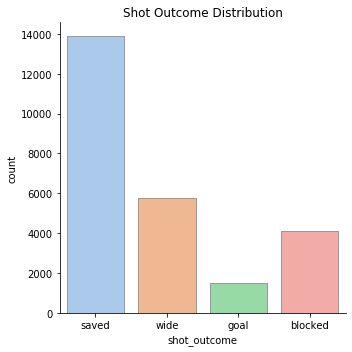

In [30]:
#plt.hist(all_shot_df.loc[:,"shot_outcome"])
sns.catplot(x="shot_outcome", kind="count",
            palette="pastel", edgecolor=".6",
            data=all_shot_df);
plt.title("Shot Outcome Distribution");
plt.tight_layout()

In [31]:
all_shot_df.loc[:,"shot_outcome"].value_counts()/sum(all_shot_df.loc[:,"shot_outcome"].value_counts())

saved      0.549460
wide       0.229070
blocked    0.161699
goal       0.059771
Name: shot_outcome, dtype: float64

In [32]:
ngoals = sum(all_shot_df.loc[:,"shot_outcome"]=="goal")
nsaves = sum(all_shot_df.loc[:,"shot_outcome"]=="saved")
nengs = sum((all_shot_df.loc[:,"isENG"]))
totalshots = (ngoals-nengs) + nsaves

print(ngoals,nsaves,nengs)
print(nsaves/totalshots)

1510 13881 70
0.9060113569610339


We can also look at the number of shots per 60 minutes, first we have to calculate the total time each team played over the season, we'll do this for home and away games separately.

In [33]:
team_minutes = all_shot_df.groupby(
    ["team_name","match_id"]
)[['match_length']].mean().reset_index().groupby("team_name")["match_length"].sum()
team_minutes

team_name
Belfast Giants         174187
Cardiff Devils         166788
Coventry Blaze         174410
Dundee Stars           173923
Fife Flyers            177518
Glasgow Clan           174549
Guildford Flames       171139
Manchester Storm       179007
Nottingham Panthers    167667
Sheffield Steelers     176950
Name: match_length, dtype: int64

In [34]:
ha_team_minutes = all_shot_df.groupby(
    ["team_name","match_id","home_game"]
)[['match_length']].mean().reset_index().groupby(["team_name","home_game"])["match_length"].sum()
ha_team_minutes

team_name            home_game
Belfast Giants       False        90957
                     True         83230
Cardiff Devils       False        83173
                     True         83615
Coventry Blaze       False        87726
                     True         86684
Dundee Stars         False        87000
                     True         86923
Fife Flyers          False        86848
                     True         90670
Glasgow Clan         False        87619
                     True         86930
Guildford Flames     False        83768
                     True         87371
Manchester Storm     False        87000
                     True         92007
Nottingham Panthers  False        83860
                     True         83807
Sheffield Steelers   False        90118
                     True         86832
Name: match_length, dtype: int64

In [35]:
all_shot_df.groupby("team_name")['match_id'].nunique()

team_name
Belfast Giants         48
Cardiff Devils         46
Coventry Blaze         48
Dundee Stars           48
Fife Flyers            49
Glasgow Clan           48
Guildford Flames       47
Manchester Storm       49
Nottingham Panthers    46
Sheffield Steelers     49
Name: match_id, dtype: int64

In [36]:
teamcolours = {
    "Belfast Giants":"#148c99ff",
    "Cardiff Devils":"#cc0929ff",
    "Coventry Blaze":"#0a3369ff",
    "Dundee Stars":"#032c54ff",
    "Fife Flyers":"#f9cf37ff",
    "Glasgow Clan":"#614f9bff",
    "Guildford Flames":"#91052eff",
    "Manchester Storm":"#6f359eff",
    "Nottingham Panthers":"#e6a437ff",
    "Sheffield Steelers":"#fd8a25ff"
}
teamcols = [
    "#148c99ff",
    "#cc0929ff",
    "#0a3369ff",
    "#032c54ff",
    "#f9cf37ff",
    "#614f9bff",
    "#91052eff",
    "#6f359eff",
    "#e6a437ff",
    "#fd8a25ff"
    ]
ha_teamcols = np.ravel([[c,c] for c in teamcols])


In [37]:
shotspergamedf = pd.DataFrame((
    3600.*all_shot_df.groupby("team_name")['shot_outcome'].count()/
    team_minutes
))
shotspergamedf.loc[:,"colour"] = teamcols
shotspergamedf.rename(columns={0:"shotspergame"},inplace=True)
shotspergamedf = shotspergamedf.reset_index()
shotspergamedf =shotspergamedf.sort_values(by="shotspergame",ascending=False)
shotspergamedf

,team_name,shotspergame,colour
9,Sheffield Steelers,58.877649,#fd8a25ff
1,Cardiff Devils,57.975394,#cc0929ff
0,Belfast Giants,54.190037,#148c99ff
6,Guildford Flames,53.114720,#91052eff
2,Coventry Blaze,52.696520,#0a3369ff
8,Nottingham Panthers,52.217789,#e6a437ff
3,Dundee Stars,50.774193,#032c54ff
7,Manchester Storm,50.538806,#6f359eff
5,Glasgow Clan,47.704656,#614f9bff
4,Fife Flyers,46.075328,#f9cf37ff


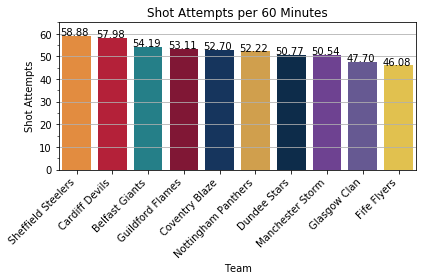

In [38]:
ax = sns.barplot(x = "team_name",y="shotspergame",data=shotspergamedf,palette=shotspergamedf.loc[:,"colour"])
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Shot Attempts per 60 Minutes");
plt.ylabel("Shot Attempts")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,65)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

In [39]:
ha_shotspergamedf = pd.DataFrame((
    3600.*all_shot_df.groupby(["team_name","home_game"])['shot_outcome'].count()/
    ha_team_minutes
))

ha_shotspergamedf.loc[:,"colour"] = ha_teamcols
ha_shotspergamedf.rename(columns={0:"shotspergame"},inplace=True)
ha_shotspergamedf = ha_shotspergamedf.reset_index()
ha_shotspergamedf.loc[ha_shotspergamedf.loc[:,"home_game"]==True,"home_game"] = " Home"
ha_shotspergamedf.loc[ha_shotspergamedf.loc[:,"home_game"]==False,"home_game"] = " Away"
ha_shotspergamedf.loc[:,"team_home"] = ha_shotspergamedf.loc[:,"team_name"] +ha_shotspergamedf.loc[:,"home_game"]
#ha_shotspergamedf =ha_shotspergamedf.sort_values(by="shotspergame",ascending=False)
ha_shotspergamedf

,team_name,home_game,shotspergame,colour,team_home
0,Belfast Giants,Away,52.996471,#148c99ff,Belfast Giants Away
1,Belfast Giants,Home,55.494413,#148c99ff,Belfast Giants Home
2,Cardiff Devils,Away,48.520554,#cc0929ff,Cardiff Devils Away
3,Cardiff Devils,Home,67.380255,#cc0929ff,Cardiff Devils Home
4,Coventry Blaze,Away,48.423500,#0a3369ff,Coventry Blaze Away
5,Coventry Blaze,Home,57.020904,#0a3369ff,Coventry Blaze Home
6,Dundee Stars,Away,50.110345,#032c54ff,Dundee Stars Away
7,Dundee Stars,Home,51.438630,#032c54ff,Dundee Stars Home
8,Fife Flyers,Away,44.187546,#f9cf37ff,Fife Flyers Away
9,Fife Flyers,Home,47.883534,#f9cf37ff,Fife Flyers Home


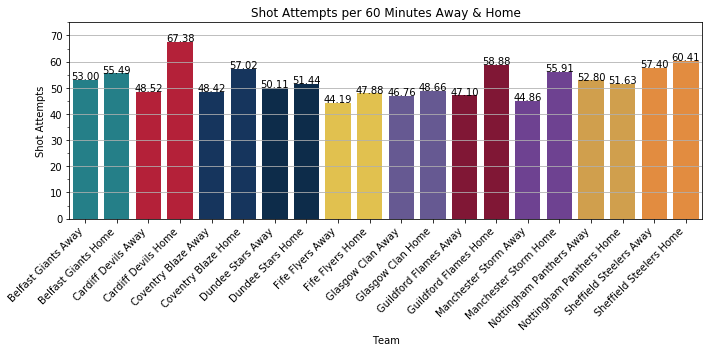

In [40]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x = "team_home",y="shotspergame",data=ha_shotspergamedf,palette=ha_shotspergamedf.loc[:,"colour"])
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Shot Attempts per 60 Minutes Away & Home");
plt.ylabel("Shot Attempts")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,75)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

In [41]:
ha_shottypespergamedf = pd.DataFrame((
    3600.*all_shot_df.loc[all_shot_df.loc[:,"isENG"]==False,:].groupby(["team_name","home_game"])['goal'].sum()/
    ha_team_minutes
))

ha_shottypespergamedf.loc[:,"colour"] = ha_teamcols
ha_shottypespergamedf.rename(columns={0:"goalspergame"},inplace=True)
ha_shottypespergamedf = ha_shottypespergamedf.reset_index()
ha_shottypespergamedf.loc[ha_shottypespergamedf.loc[:,"home_game"]==True,"home_game"] = " Home"
ha_shottypespergamedf.loc[ha_shottypespergamedf.loc[:,"home_game"]==False,"home_game"] = " Away"
ha_shottypespergamedf.loc[:,"team_home"] = ha_shottypespergamedf.loc[:,"team_name"] +ha_shottypespergamedf.loc[:,"home_game"]
#ha_shotspergamedf =ha_shotspergamedf.sort_values(by="shotspergame",ascending=False)
ha_shottypespergamedf

,team_name,home_game,goalspergame,colour,team_home
0,Belfast Giants,Away,2.651803,#148c99ff,Belfast Giants Away
1,Belfast Giants,Home,3.200769,#148c99ff,Belfast Giants Home
2,Cardiff Devils,Away,2.943263,#cc0929ff,Cardiff Devils Away
3,Cardiff Devils,Home,3.702685,#cc0929ff,Cardiff Devils Home
4,Coventry Blaze,Away,3.159839,#0a3369ff,Coventry Blaze Away
5,Coventry Blaze,Home,3.903835,#0a3369ff,Coventry Blaze Home
6,Dundee Stars,Away,2.482759,#032c54ff,Dundee Stars Away
7,Dundee Stars,Home,3.064781,#032c54ff,Dundee Stars Home
8,Fife Flyers,Away,2.031135,#f9cf37ff,Fife Flyers Away
9,Fife Flyers,Home,2.819014,#f9cf37ff,Fife Flyers Home


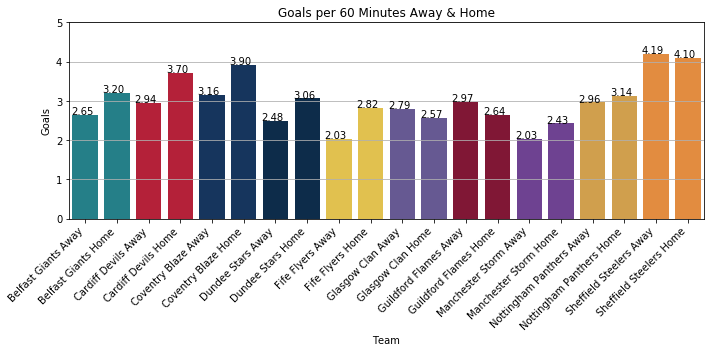

In [42]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x = "team_home",y="goalspergame",data=ha_shottypespergamedf,palette=ha_shottypespergamedf.loc[:,"colour"])
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Goals per 60 Minutes Away & Home");
plt.ylabel("Goals")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,5)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

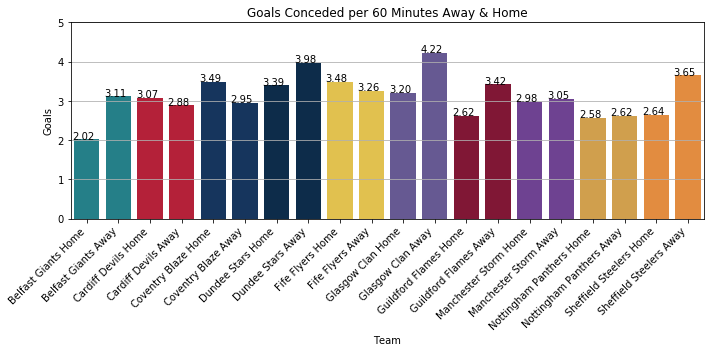

In [43]:
ha_shottypespergamecondf = pd.DataFrame((
    3600.*all_shot_df.groupby(["opposition_name","home_game"])['goal'].sum()/
    ha_team_minutes
))

ha_shottypespergamecondf.loc[:,"colour"] = ha_teamcols
ha_shottypespergamecondf.rename(columns={0:"goalspergame"},inplace=True)
ha_shottypespergamecondf = ha_shottypespergamecondf.reset_index()
ha_shottypespergamecondf.loc[ha_shottypespergamecondf.loc[:,"home_game"]==True,"home_game"] = " Away"
ha_shottypespergamecondf.loc[ha_shottypespergamecondf.loc[:,"home_game"]==False,"home_game"] = " Home"
ha_shottypespergamecondf.loc[:,"team_home"] = ha_shottypespergamecondf.loc[:,"opposition_name"] +ha_shottypespergamecondf.loc[:,"home_game"]
#ha_shotspergamedf =ha_shotspergamedf.sort_values(by="shotspergame",ascending=False)
#ha_shottypespergamecondf

plt.figure(figsize=(10,5))
ax = sns.barplot(x = "team_home",y="goalspergame",data=ha_shottypespergamecondf,palette=ha_shottypespergamecondf.loc[:,"colour"])
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Goals Conceded per 60 Minutes Away & Home");
plt.ylabel("Goals")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,5)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

In [44]:
shottypespergamepropdf = pd.DataFrame(
    all_shot_df.groupby("team_name")['shot_outcome'].value_counts()/
    all_shot_df.groupby("team_name")['match_id'].count()
)
shottypespergamepropdf = shottypespergamepropdf.reset_index()
shottypespergamepropdf
pivotprop_df = shottypespergamepropdf.pivot(index="team_name", columns="shot_outcome", values=0)
pivotprop_df.round(decimals=3)

shot_outcome,blocked,goal,saved,wide
team_name,,,,
Belfast Giants,0.143,0.056,0.560,0.240
Cardiff Devils,0.190,0.060,0.526,0.224
Coventry Blaze,0.170,0.070,0.541,0.219
Dundee Stars,0.138,0.059,0.581,0.222
Fife Flyers,0.150,0.055,0.586,0.210
Glasgow Clan,0.150,0.060,0.555,0.235
Guildford Flames,0.195,0.057,0.524,0.224
Manchester Storm,0.135,0.045,0.588,0.232
Nottingham Panthers,0.148,0.060,0.530,0.262


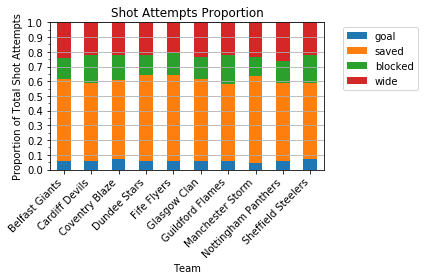

In [45]:
ax = pivotprop_df.loc[:,["goal","saved","blocked","wide"]].plot(kind="bar",stacked=True)
plt.title("Shot Attempts Proportion");
plt.ylabel("Proportion of Total Shot Attempts")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,1)
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
plt.grid(b=True,axis="y",which="major")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

In [46]:
shottypespergamedf = pd.DataFrame(
    3600*all_shot_df.groupby("team_name")['shot_outcome'].value_counts()/team_minutes
)
shottypespergamedf = shottypespergamedf.reset_index()
shottypespergamedf
pivot_df = shottypespergamedf.pivot(index="team_name", columns="shot_outcome", values=0)
pivot_df.round(decimals=2)

shot_outcome,blocked,goal,saved,wide
team_name,,,,
Belfast Giants,7.77,3.06,30.34,13.02
Cardiff Devils,11.01,3.45,30.52,12.99
Coventry Blaze,8.94,3.69,28.53,11.54
Dundee Stars,7.02,2.98,29.50,11.28
Fife Flyers,6.90,2.51,27.01,9.65
Glasgow Clan,7.18,2.87,26.46,11.20
Guildford Flames,10.35,3.05,27.81,11.91
Manchester Storm,6.80,2.29,29.70,11.74
Nottingham Panthers,7.75,3.13,27.65,13.68


In [47]:
opshotspergamedf = pd.DataFrame((
    3600.*all_shot_df.groupby("opposition_name")['shot_outcome'].count()/
    team_minutes
))
opshotspergamedf.loc[:,"colour"] = teamcols
opshotspergamedf.rename(columns={0:"shotspergame"},inplace=True)
opshotspergamedf = opshotspergamedf.reset_index()
opshotspergamedf =opshotspergamedf.sort_values(by="shotspergame",ascending=False)
opshotspergamedf

,opposition_name,shotspergame,colour
7,Manchester Storm,56.411202,#6f359eff
4,Fife Flyers,55.586476,#f9cf37ff
5,Glasgow Clan,55.150130,#614f9bff
2,Coventry Blaze,54.430365,#0a3369ff
3,Dundee Stars,53.175256,#032c54ff
6,Guildford Flames,52.799187,#91052eff
9,Sheffield Steelers,51.594236,#fd8a25ff
1,Cardiff Devils,49.406432,#cc0929ff
8,Nottingham Panthers,49.297715,#e6a437ff
0,Belfast Giants,45.592381,#148c99ff


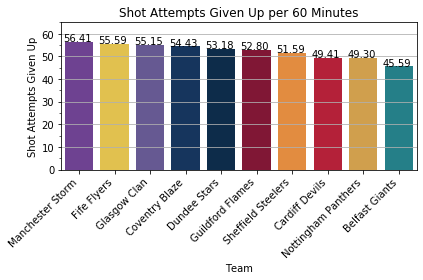

In [48]:
ax = sns.barplot(
    x = "opposition_name",
    y="shotspergame",
    data=opshotspergamedf,
    palette=opshotspergamedf.loc[:,"colour"]
)
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Shot Attempts Given Up per 60 Minutes");
plt.ylabel("Shot Attempts Given Up")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,65)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

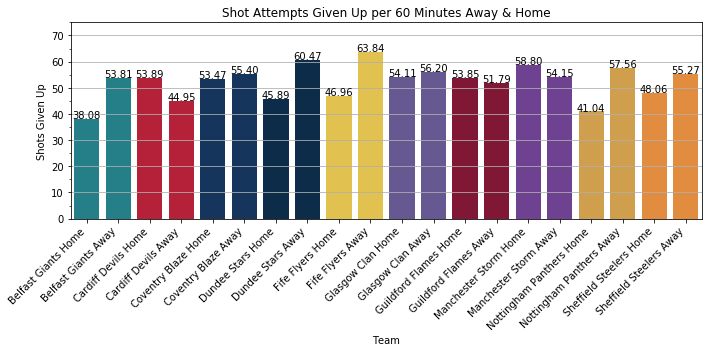

In [49]:
ha_opshotspergamedf = pd.DataFrame((
    3600.*all_shot_df.groupby(["opposition_name","home_game"])['shot_outcome'].count()/
    ha_team_minutes
))

ha_opshotspergamedf.loc[:,"colour"] = ha_teamcols
ha_opshotspergamedf.rename(columns={0:"shotspergame"},inplace=True)
ha_opshotspergamedf = ha_opshotspergamedf.reset_index()
ha_opshotspergamedf.loc[ha_opshotspergamedf.loc[:,"home_game"]==True,"home_game"] = " Away"
ha_opshotspergamedf.loc[ha_opshotspergamedf.loc[:,"home_game"]==False,"home_game"] = " Home"
ha_opshotspergamedf.loc[:,"team_home"] = ha_opshotspergamedf.loc[:,"opposition_name"]+ha_opshotspergamedf.loc[:,"home_game"]
#ha_shotspergamedf =ha_shotspergamedf.sort_values(by="shotspergame",ascending=False)
ha_opshotspergamedf
plt.figure(figsize=(10,5))
ax = sns.barplot(
    x = "team_home",
    y="shotspergame",
    data=ha_opshotspergamedf,
    palette=ha_opshotspergamedf.loc[:,"colour"]
)
for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1-0.05, p.get_height() * 1.005))
plt.title("Shot Attempts Given Up per 60 Minutes Away & Home");
plt.ylabel("Shots Given Up")
plt.xticks(rotation=45,ha="right")
plt.xlabel("Team");
plt.ylim(0,75)
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(b=True,axis="y",which="major")
plt.tight_layout()

### Shot Maps

Shot maps are generated in the external ```shotplots.py``` file to save space in the notebook (a lot of the code was repetition). Let's take a look at shot maps for a couple of teams and a couple of players. Then we'll look at all teams in the league.

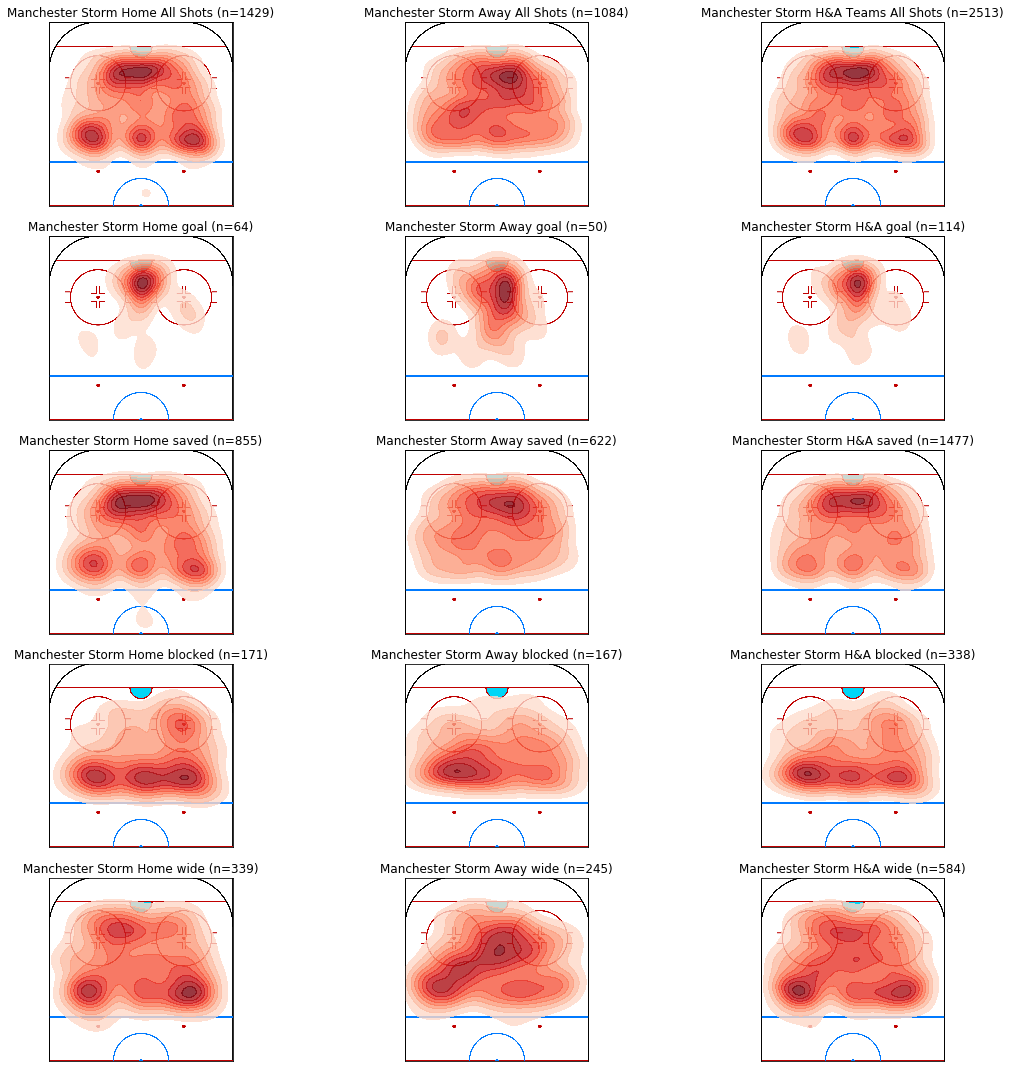

In [50]:
sp.plotteammaps(all_shot_df,"Manchester Storm",base_image)

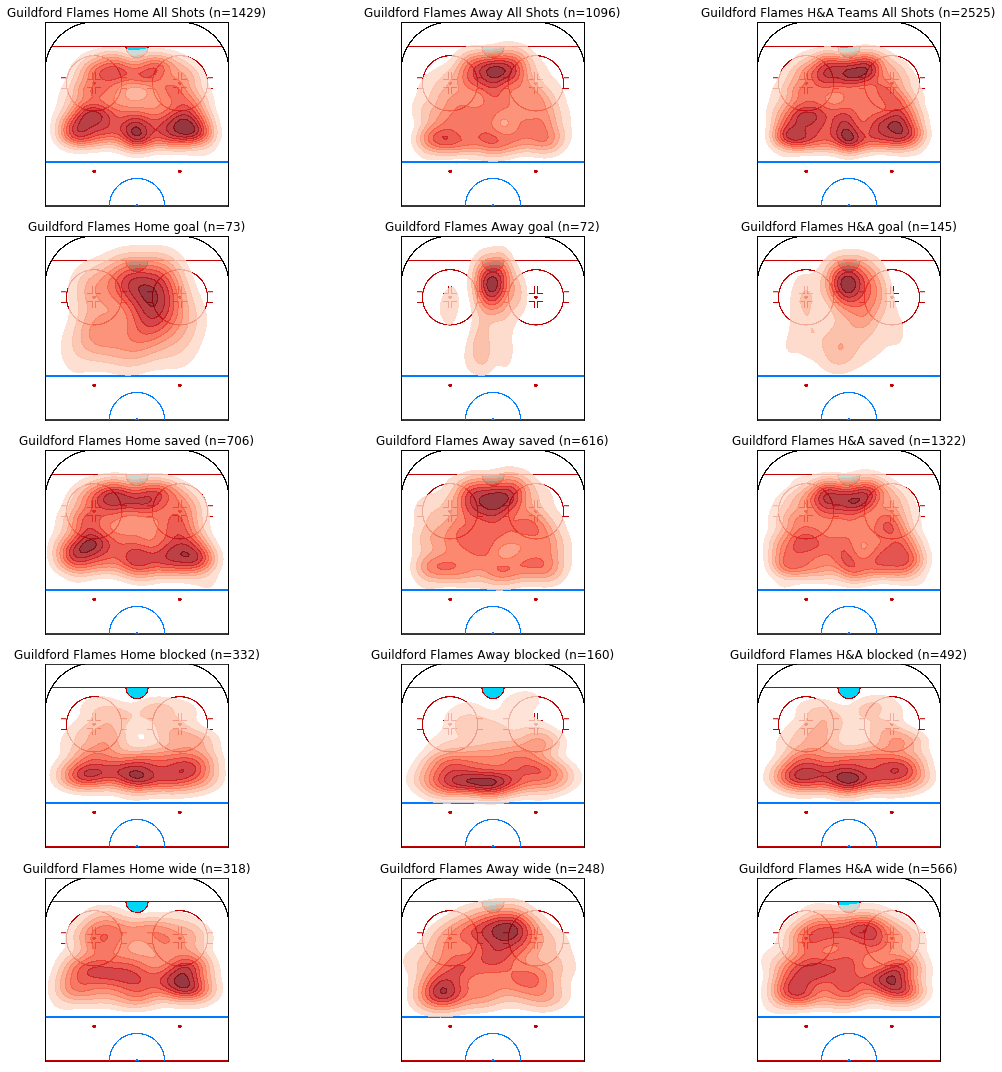

In [51]:
sp.plotteammaps(all_shot_df,"Guildford Flames",base_image)

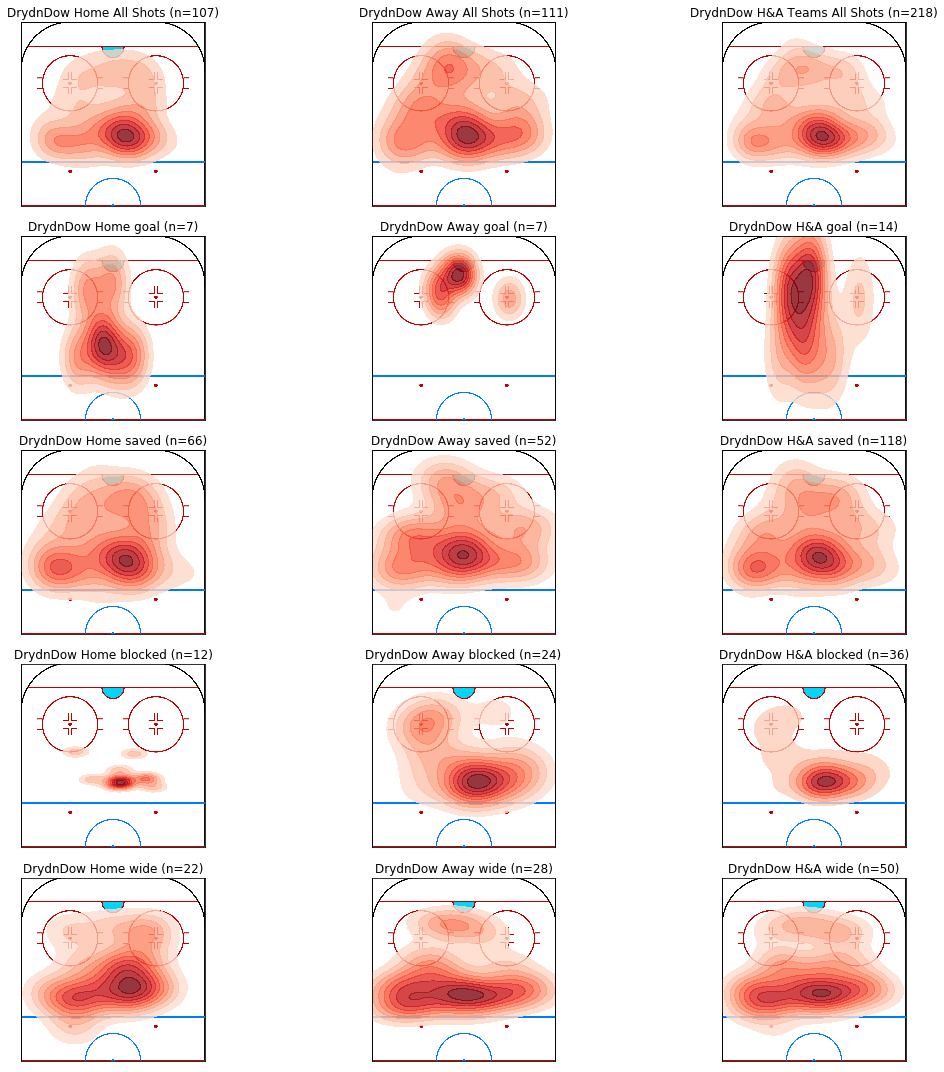

In [52]:
sp.plotplayermaps(all_shot_df,"DrydnDow",base_image)

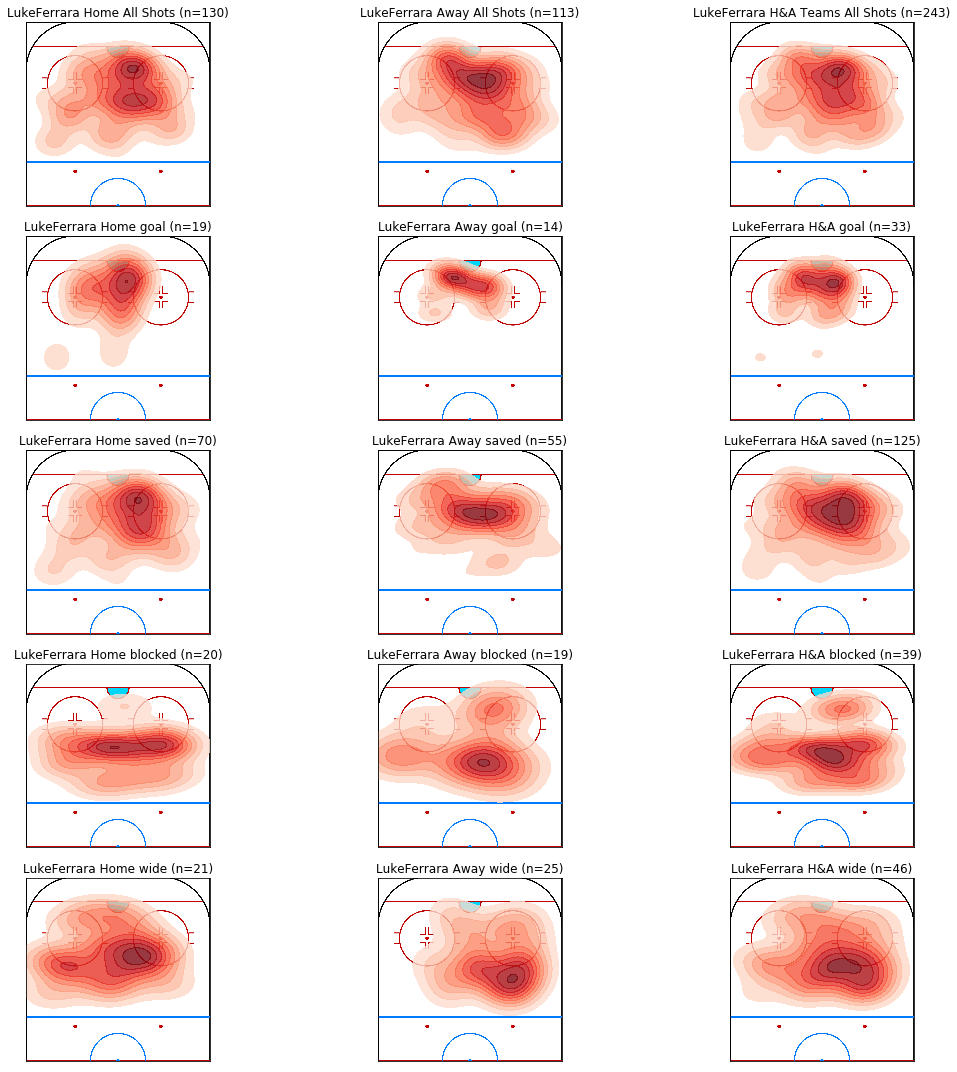

In [53]:
sp.plotplayermaps(all_shot_df,"LukeFerrara",base_image)

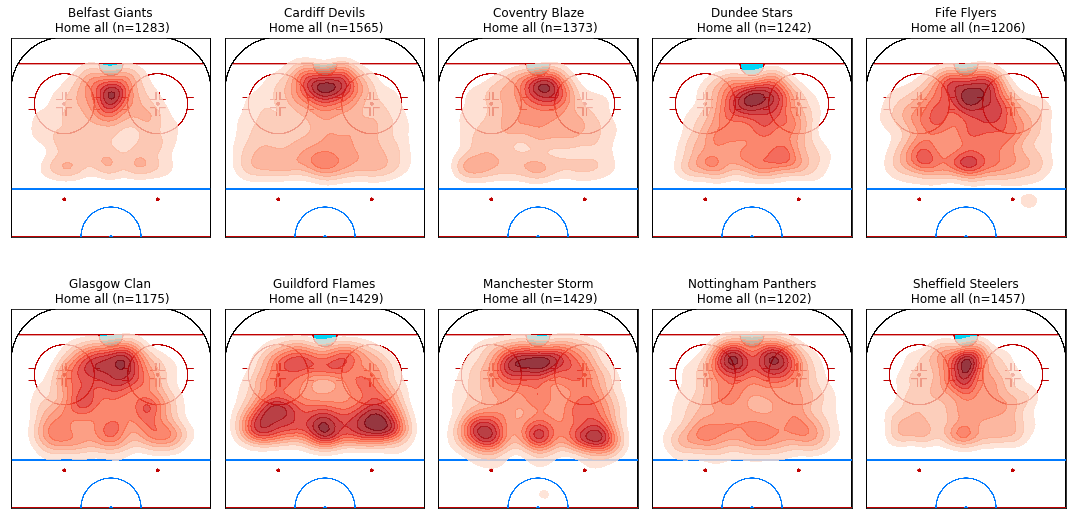

In [54]:
sp.plotallteamsmaps(all_shot_df,True,"all",base_image)

In [55]:
homeshotmaps = sp.genallteamsmaps(all_shot_df,True,"all")
homemeanshotmap = np.mean(homeshotmaps,axis=2)
homemeanshotmap = homemeanshotmap/np.sum(homemeanshotmap)


/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


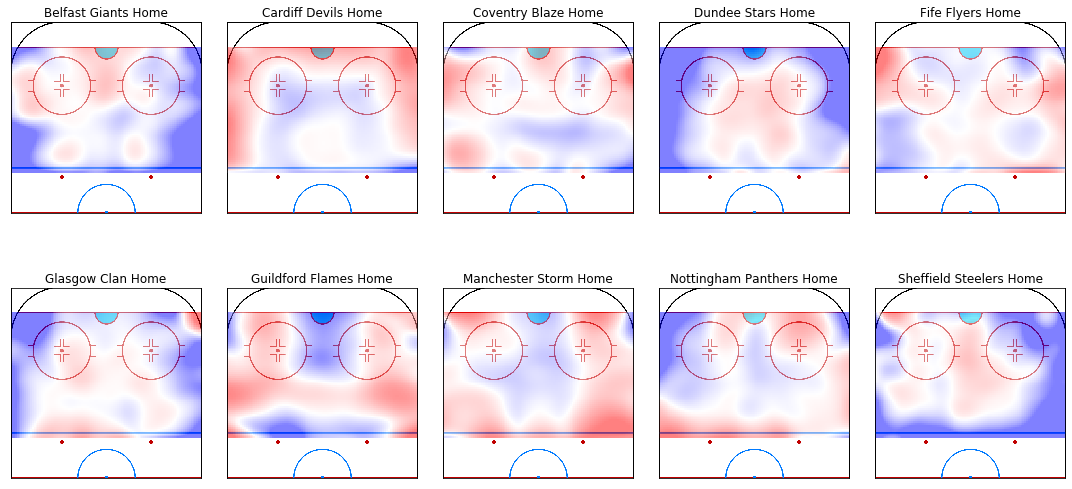

In [56]:
xx, yy = np.mgrid[-50:51,0:101]
f, axs = plt.subplots(2,5,figsize=(15, 8))
teams = np.sort(all_shot_df.loc[:,"team_name"].unique())
for i in range(0,len(teams)):
    p = np.rot90(homeshotmaps[:,:,i]/homemeanshotmap)
    p[80:,:]=0.
    p[:13,:]=0.
    if i <5:
        axs[0,i].imshow(base_image,extent = (-50,50,0,100))
        axs[0,i].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[0,i].get_images()[1].set_clim(-1,1)
        axs[0,i].set_title(teams[i] + " Home")
        axs[0,i].set_xlim(-50,50)
        axs[0,i].set_ylim(0,100)
        axs[0,i].set_xlabel('')
        axs[0,i].set_ylabel('')
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        #axs[0,i].get_images()[1].colorbar()
    else:
        axs[1,i-5].imshow(base_image,extent = (-50,50,0,100))
        axs[1,i-5].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[1,i-5].get_images()[1].set_clim(-1,1)
        axs[1,i-5].set_title(teams[i] + " Home")
        axs[1,i-5].set_xlim(-50,50)
        axs[1,i-5].set_ylim(0,100)
        axs[1,i-5].set_xlabel('')
        axs[1,i-5].set_ylabel('')
        axs[1,i-5].set_xticks([])
        axs[1,i-5].set_yticks([])
#        plt.colorbar()
plt.tight_layout();

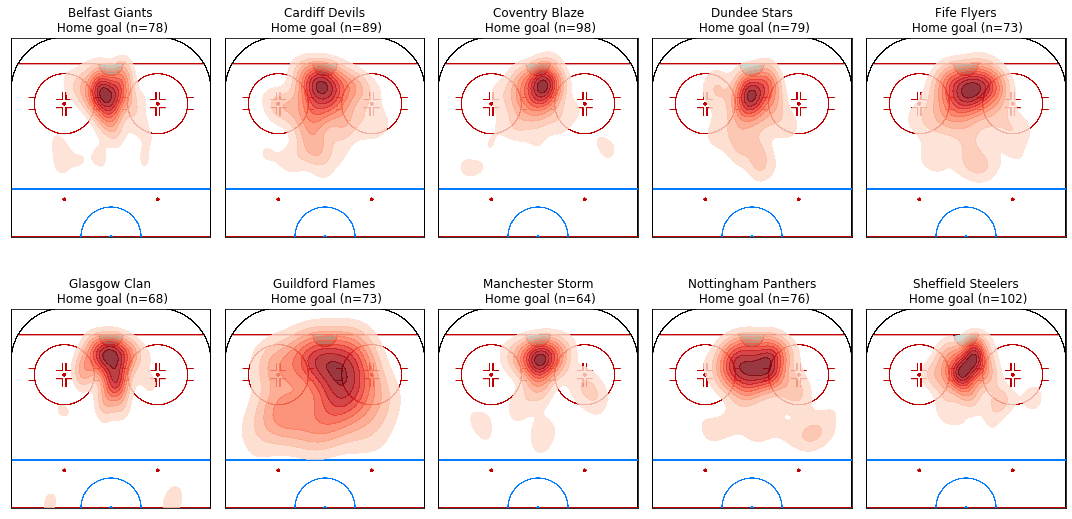

In [57]:
sp.plotallteamsmaps(all_shot_df,True,"goal",base_image)

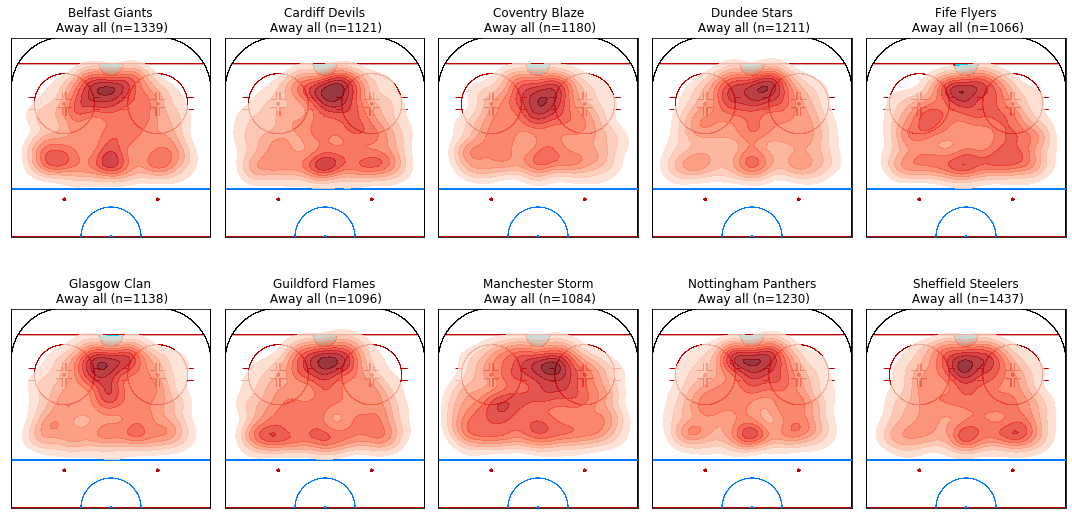

In [58]:
sp.plotallteamsmaps(all_shot_df,False,"all",base_image)

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


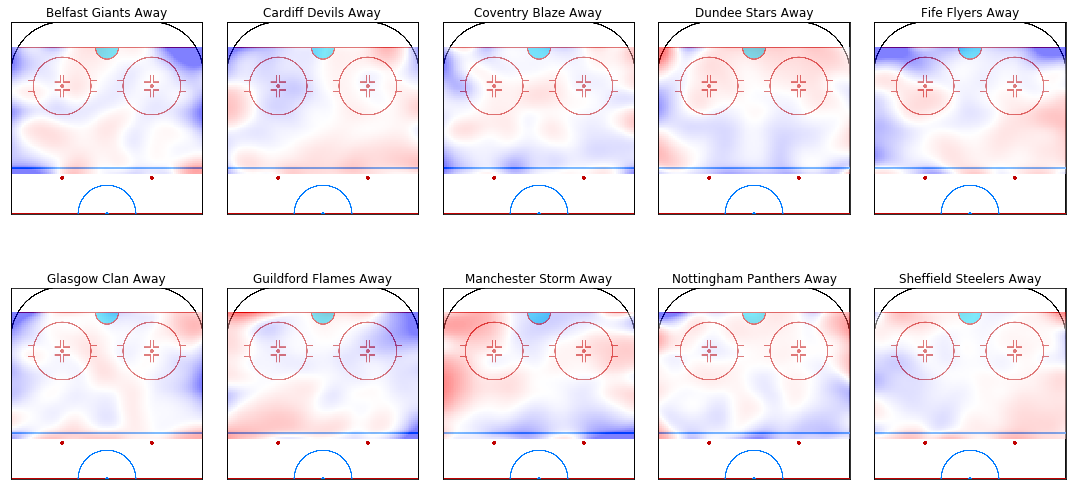

In [59]:

awayshotmaps = sp.genallteamsmaps(all_shot_df,False,"all")
awaymeanshotmap = np.mean(awayshotmaps,axis=2)
awaymeanshotmap = awaymeanshotmap/np.sum(awaymeanshotmap)

xx, yy = np.mgrid[-50:51,0:101]
f, axs = plt.subplots(2,5,figsize=(15, 8))
teams = np.sort(all_shot_df.loc[:,"team_name"].unique())
for i in range(0,len(teams)):
    p = np.rot90(awayshotmaps[:,:,i]/awaymeanshotmap)
    p[80:,:]=0.
    p[:13,:]=0.
    if i <5:
        axs[0,i].imshow(base_image,extent = (-50,50,0,100))
        axs[0,i].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[0,i].get_images()[1].set_clim(-1,1)
        axs[0,i].set_title(teams[i] + " Away")
        axs[0,i].set_xlim(-50,50)
        axs[0,i].set_ylim(0,100)
        axs[0,i].set_xlabel('')
        axs[0,i].set_ylabel('')
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        #axs[0,i].get_images()[1].colorbar()
    else:
        axs[1,i-5].imshow(base_image,extent = (-50,50,0,100))
        axs[1,i-5].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[1,i-5].get_images()[1].set_clim(-1,1)
        axs[1,i-5].set_title(teams[i] + " Away")
        axs[1,i-5].set_xlim(-50,50)
        axs[1,i-5].set_ylim(0,100)
        axs[1,i-5].set_xlabel('')
        axs[1,i-5].set_ylabel('')
        axs[1,i-5].set_xticks([])
        axs[1,i-5].set_yticks([])
#        plt.colorbar()
plt.tight_layout();

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


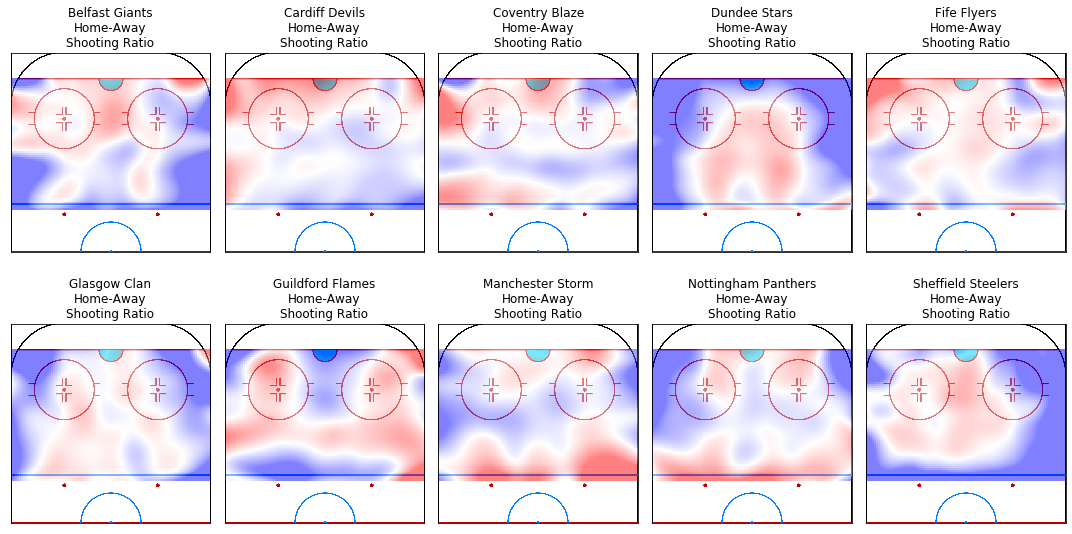

In [60]:
xx, yy = np.mgrid[-50:51,0:101]
f, axs = plt.subplots(2,5,figsize=(15, 8))
teams = np.sort(all_shot_df.loc[:,"team_name"].unique())
for i in range(0,len(teams)):
    p = np.rot90(homeshotmaps[:,:,i]/awayshotmaps[:,:,i])
    p[80:,:]=0.
    p[:13,:]=0.
    if i <5:
        axs[0,i].imshow(base_image,extent = (-50,50,0,100))
        axs[0,i].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[0,i].get_images()[1].set_clim(-1,1)
        axs[0,i].set_title(teams[i] + "\nHome-Away\nShooting Ratio")
        axs[0,i].set_xlim(-50,50)
        axs[0,i].set_ylim(0,100)
        axs[0,i].set_xlabel('')
        axs[0,i].set_ylabel('')
        axs[0,i].set_xticks([])
        axs[0,i].set_yticks([])
        #axs[0,i].get_images()[1].colorbar()
    else:
        axs[1,i-5].imshow(base_image,extent = (-50,50,0,100))
        axs[1,i-5].imshow(np.log(p),extent = (-50,50,0,100),cmap="bwr",alpha = 0.5)
        axs[1,i-5].get_images()[1].set_clim(-1,1)
        axs[1,i-5].set_title(teams[i] + "\nHome-Away\nShooting Ratio")
        axs[1,i-5].set_xlim(-50,50)
        axs[1,i-5].set_ylim(0,100)
        axs[1,i-5].set_xlabel('')
        axs[1,i-5].set_ylabel('')
        axs[1,i-5].set_xticks([])
        axs[1,i-5].set_yticks([])
#        plt.colorbar()

plt.tight_layout();

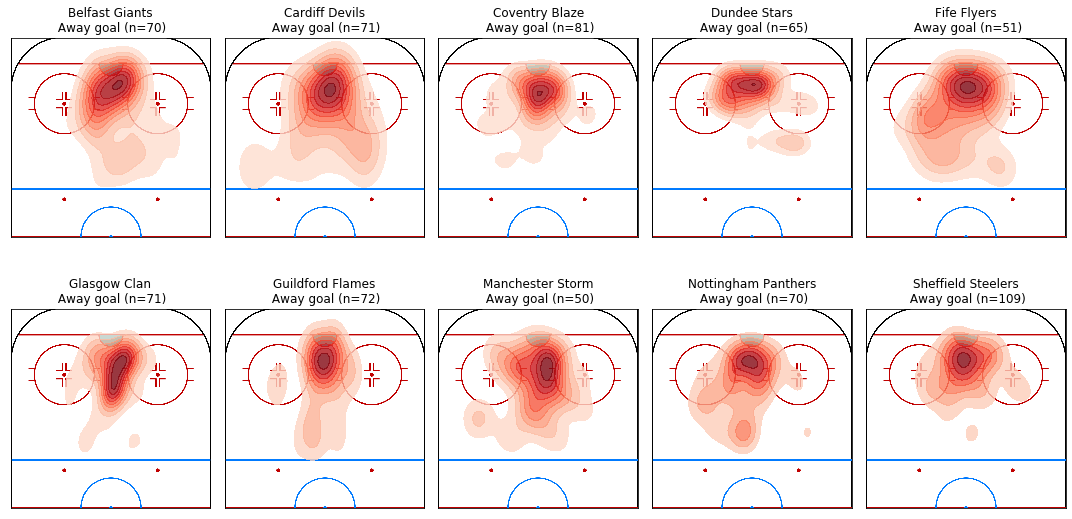

In [61]:
sp.plotallteamsmaps(all_shot_df,False,"goal",base_image)

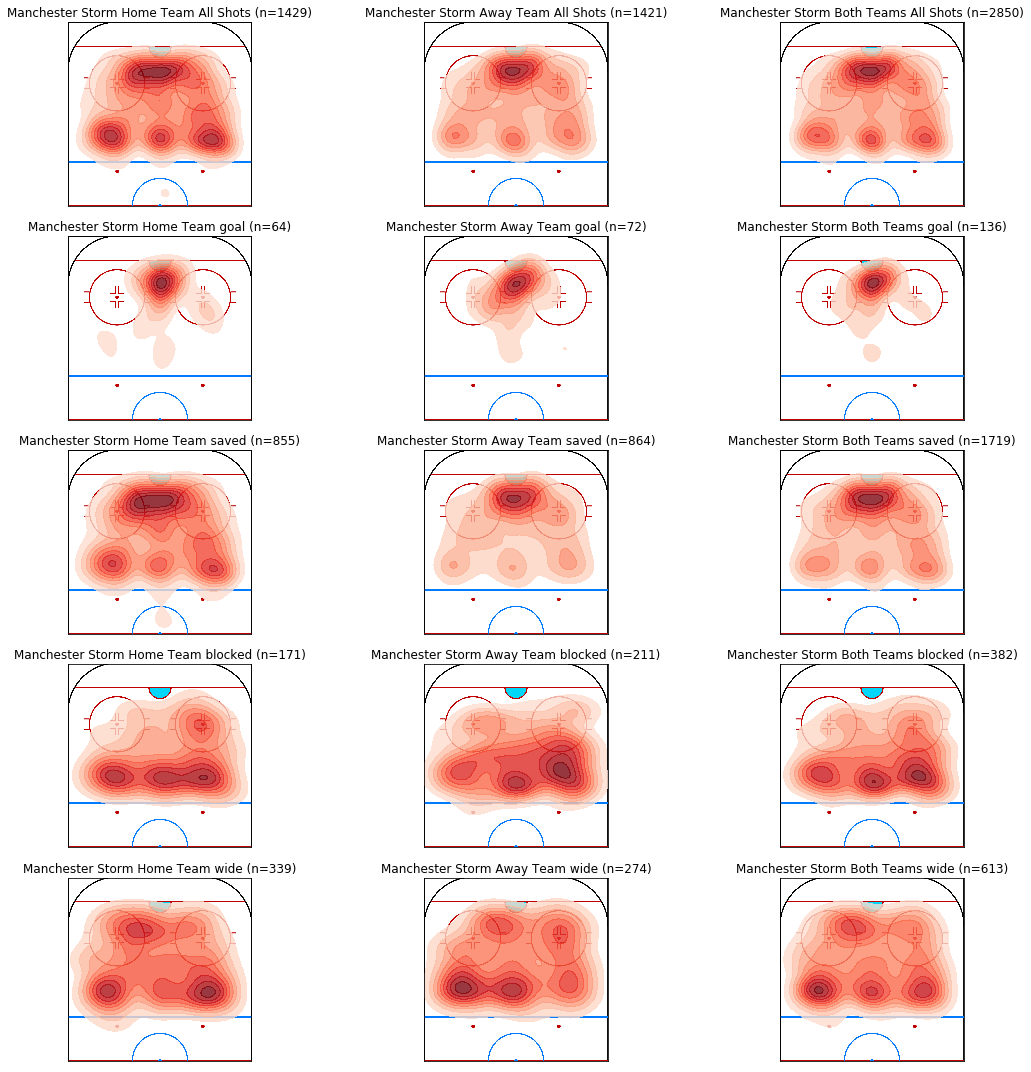

In [62]:
sp.plotrinkmaps(all_shot_df,"Manchester Storm",base_image)

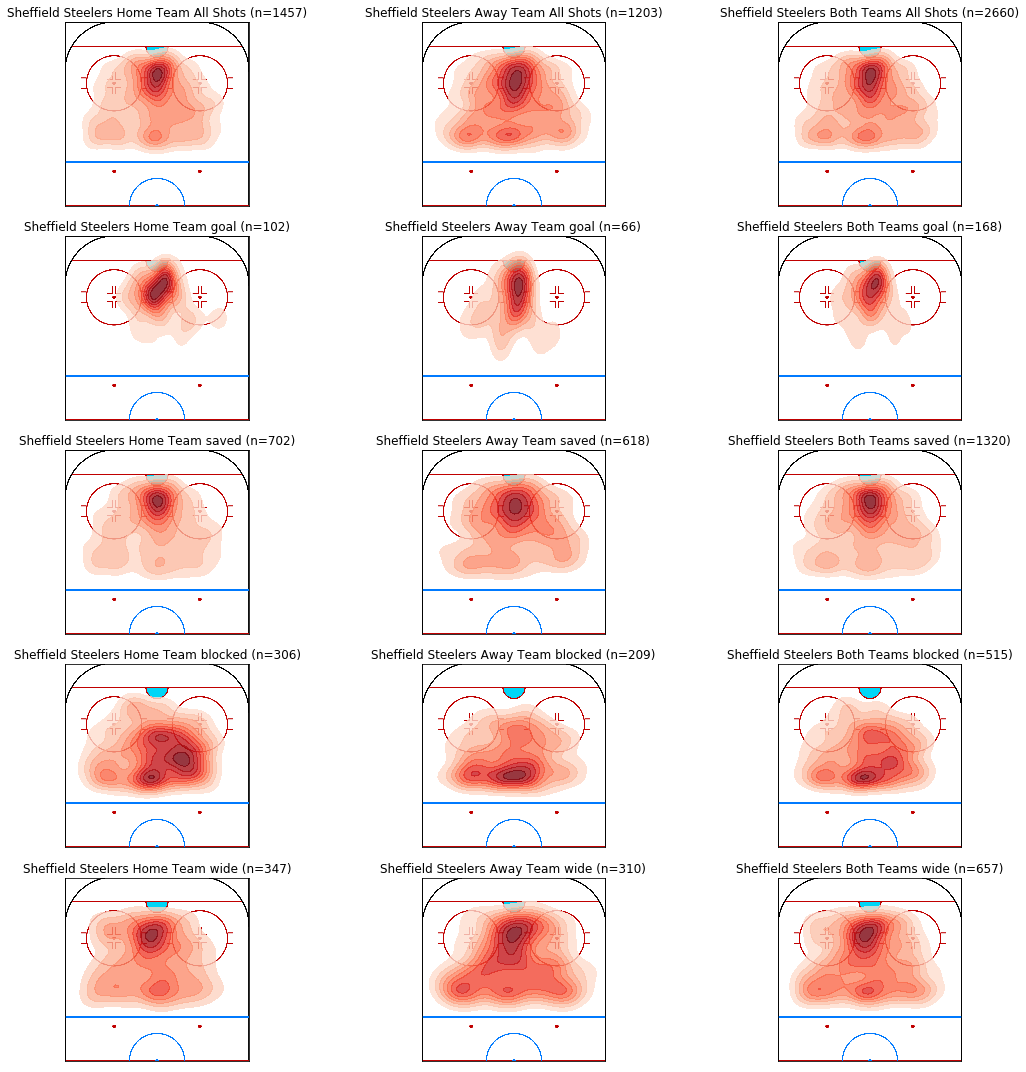

In [63]:
sp.plotrinkmaps(all_shot_df,"Sheffield Steelers",base_image)

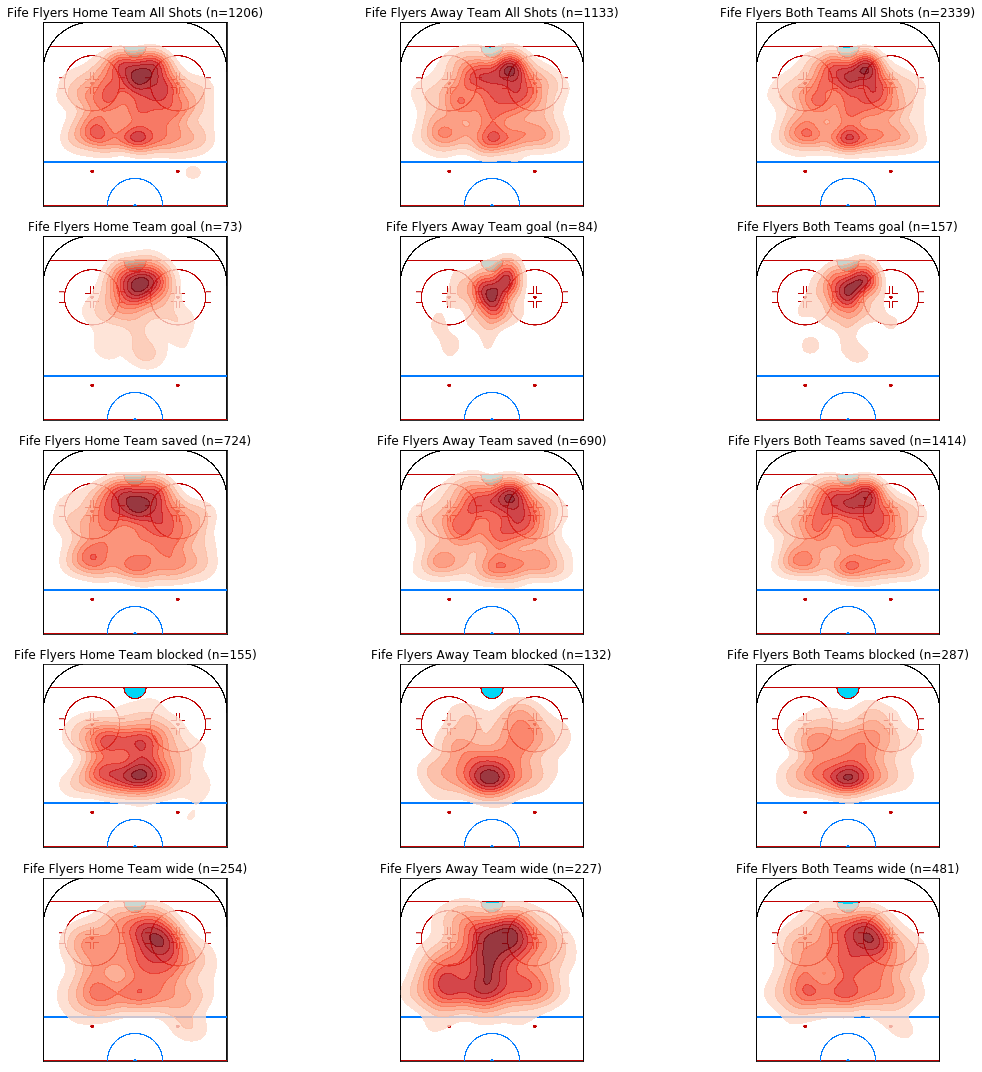

In [64]:
sp.plotrinkmaps(all_shot_df,"Fife Flyers",base_image)

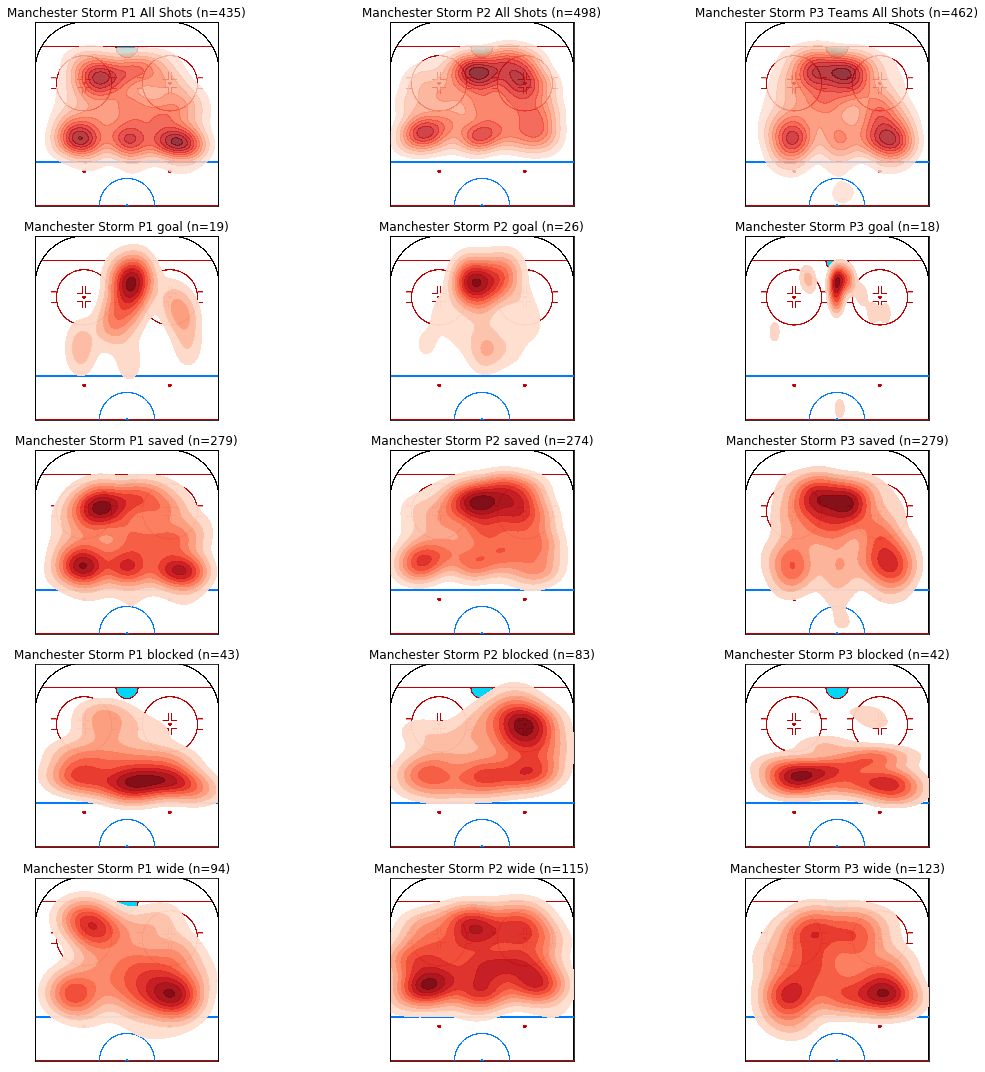

In [65]:
sp.plotteamhomeperiodmaps(all_shot_df,"Manchester Storm",base_image)

### Shot Distance
We can look at histograms of the shot distances (in metres) and look at home the probability of a goal changes with distance. First, we'll plot a contour map of distances overlaid on the ice rink.

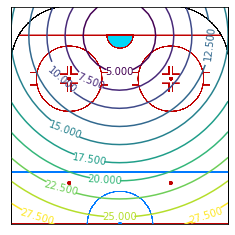

In [66]:
# Olympic sized rinks only
xx, yy = np.mgrid[-15:16,0:31]
i = 0
goal_x_m = goaly*rinklengths[i]/200.
goal_y_m = goalx*rinkwidths[i]/200.
dists = np.sqrt(np.power(goal_x_m-yy,2)+np.power(goal_y_m-xx,2))
plt.imshow(base_image,extent = (-15,15,0,30))
#plt.imshow(np.rot90(dists),extent = (-15,15,0,30),alpha = 0.5)
# plt.colorbar()

cs = plt.contour(xx,yy,dists,levels=np.arange(5,30,2.5))
plt.clabel(cs, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([]);

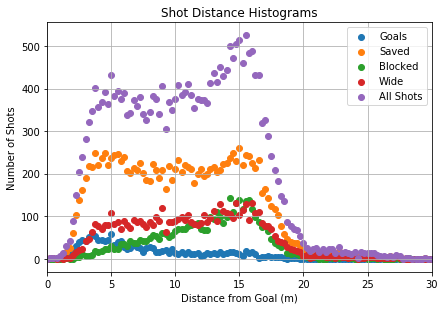

In [67]:
h_all,x_all = np.histogram(
    all_shot_df.loc[all_shot_df.loc[:,"isENG"]==False,"shotdistance_m"],
    bins=np.arange(0,60,0.25)
)
h_goal,x_goal = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="goal"),"shotdistance_m"
    ],
    bins=np.arange(0,60,0.25)
)
h_svd,x_svd = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="saved"),"shotdistance_m"
    ],
    bins=np.arange(0,60,0.25))
h_blckd,x_blckd = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="blocked"),"shotdistance_m"
    ],
    bins=np.arange(0,60,0.25))
h_wde,x_wde = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="wide"),"shotdistance_m"
    ]
    ,bins=np.arange(0,60,0.25))
plt.scatter(x_goal[:-1],h_goal,label="Goals")
plt.scatter(x_svd[:-1],h_svd,label="Saved")
plt.scatter(x_blckd[:-1],h_blckd,label="Blocked")
plt.scatter(x_wde[:-1],h_wde,label="Wide")
plt.scatter(x_all[:-1],h_all,label="All Shots")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Distance from Goal (m)")
plt.ylabel("Number of Shots")

plt.title("Shot Distance Histograms");


/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


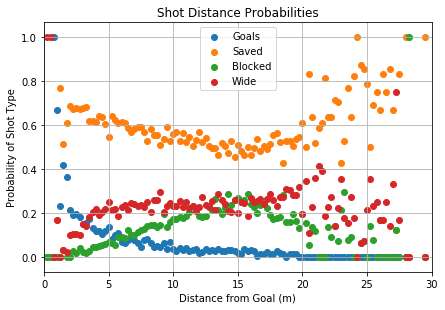

In [68]:
plt.scatter(x_goal[:-1],h_goal/h_all,label="Goals")
plt.scatter(x_svd[:-1],h_svd/h_all,label="Saved")
plt.scatter(x_blckd[:-1],h_blckd/h_all,label="Blocked")
plt.scatter(x_wde[:-1],h_wde/h_all,label="Wide")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Distance from Goal (m)")
plt.ylabel("Probability of Shot Type")

plt.title("Shot Distance Probabilities");

### Powerplay & Rebounds

Let's take a look at which shots are rebound by looking at the difference in the time between shots and the probability of scoring as a function of this time.

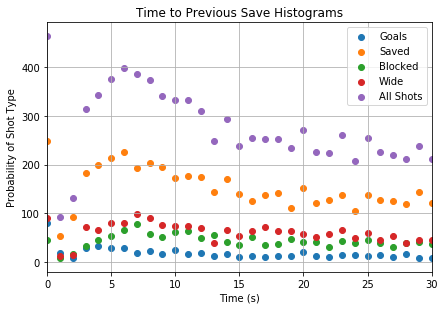

In [69]:
h_allt,x_allt = np.histogram(
    all_shot_df.loc[(all_shot_df.loc[:,"isENG"]==False),"time_to_prior_save"],
    bins=np.arange(0,60,1)
)
h_goalt,x_goalt = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="goal"),
        "time_to_prior_save"
    ],
    bins=np.arange(0,60,1)
)
h_svdt,x_svdt = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="saved"),
        "time_to_prior_save"
    ],
    bins=np.arange(0,60,1)
)
h_blckdt,x_blckdt = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="blocked"),
        "time_to_prior_save"],
    bins=np.arange(0,60,1)
)
h_wdet,x_wdet = np.histogram(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"shot_outcome"]=="wide"),"time_to_prior_save"
    ],
    bins=np.arange(0,60,1)
)
plt.scatter(x_goalt[:-1],h_goalt,label="Goals")
plt.scatter(x_svdt[:-1],h_svdt,label="Saved")
plt.scatter(x_blckdt[:-1],h_blckdt,label="Blocked")
plt.scatter(x_wdet[:-1],h_wdet,label="Wide")
plt.scatter(x_allt[:-1],h_allt,label="All Shots")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Time (s)")
plt.ylabel("Probability of Shot Type")

plt.title("Time to Previous Save Histograms");



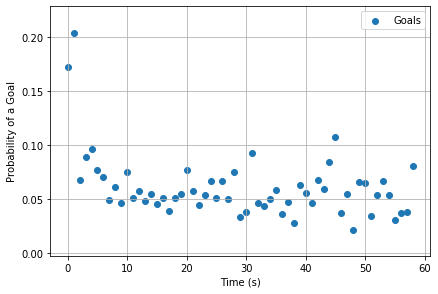

In [70]:
plt.scatter(x_goalt[:-1],h_goalt/(h_allt),label="Goals")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Probability of a Goal");

Let's also look at which teams & players had the most rebounds.

In [71]:
rebounddf = pd.DataFrame((
    all_shot_df.groupby(["team_name"])['is_saved_rebound'].sum()
))
print(100.0*rebounddf.sum()/all_shot_df.shape[0])
print(rebounddf.sum())
print(all_shot_df.shape[0])
rebounddf

is_saved_rebound    2.208764
dtype: float64
is_saved_rebound    558.0
dtype: float64
25263


,is_saved_rebound
team_name,
Belfast Giants,63.0
Cardiff Devils,44.0
Coventry Blaze,50.0
Dundee Stars,72.0
Fife Flyers,50.0
Glasgow Clan,32.0
Guildford Flames,29.0
Manchester Storm,42.0
Nottingham Panthers,55.0


In [72]:
rebounddf = pd.DataFrame((
    all_shot_df.groupby(["fullname"])['is_saved_rebound'].sum()
))
rebounddf.sort_values(by = "is_saved_rebound",ascending=False).head(20)

,is_saved_rebound
fullname,
KevinDufour,15.0
NikolaiLemtyugov,13.0
Marc-OlivierVallerand,13.0
MatthewCarter,10.0
RobertDowd,10.0
JohnArmstrong,9.0
BrianWard,9.0
LayneUlmer,9.0
BrendanConnolly,9.0


In [73]:
rebounddf = pd.DataFrame((
    all_shot_df.loc[all_shot_df.loc[:,"goal"]==True,:].groupby(["fullname"])['is_saved_rebound'].sum()
))
rebounddf.sort_values(by = "is_saved_rebound",ascending=False).head(20)

,is_saved_rebound
fullname,
LiamMorgan,4.0
AnthonyDeLuca,3.0
PaulCrowder,3.0
RobertDowd,3.0
MarekTrončinský,3.0
ElginPearce,3.0
SamuelHerr,2.0
ScottSimmonds,2.0
MattPohlkamp,2.0


Now we can look at shots taken when on the powerplay or when shorthanded and look at the proportion of those that are goals/blocks/saved/wide

In [74]:
strength_counts = pd.DataFrame(
    all_shot_df.loc[
        (all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"period"]<4)].
    groupby("strength")['shot_outcome'].count()
)
strength_counts.drop(labels="PS",axis=0,inplace=True)
strength_counts

,shot_outcome
strength,
3/4,2
3/5,12
4/3,29
4/4,252
4/5,698
5/3,273
5/4,4769
5/5,18906


In [75]:
shotstrngth = pd.DataFrame(all_shot_df.loc[(all_shot_df.loc[:,"isENG"]==False)&(all_shot_df.loc[:,"period"]<4)].groupby("strength")['shot_outcome'].value_counts())
shotpivot = shotstrngth.rename(columns ={"shot_outcome":"count"}).reset_index().pivot(index="strength", columns="shot_outcome", values="count")
shotpivot.drop(labels="PS",axis=0,inplace=True)
shotpivotpct = (100*shotpivot/strength_counts.values)
shotpivotpct

shot_outcome,blocked,goal,saved,wide
strength,,,,
3/4,NaN,NaN,100.000000,NaN
3/5,NaN,8.333333,50.000000,41.666667
4/3,13.793103,6.896552,41.379310,37.931034
4/4,15.476190,11.507937,49.603175,23.412698
4/5,11.747851,6.017192,62.464183,19.770774
5/3,12.454212,11.355311,54.945055,21.245421
5/4,18.410568,6.814846,50.681485,24.093101
5/5,15.973765,5.215276,55.961071,22.849889


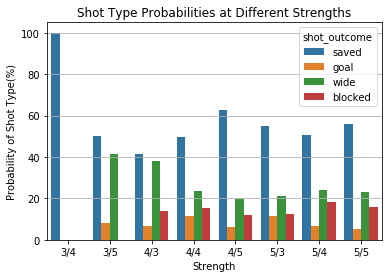

In [76]:
df = shotpivotpct.stack().reset_index()
df.rename(columns={0:"Prop"},inplace=True)
ax = sns.barplot(y="Prop", x='strength', hue='shot_outcome', data=df);
ax.set_xlabel("Strength")
ax.set_ylabel("Probability of Shot Type(%)")
ax.grid(b=True,axis="y",which="major")
ax.set_title("Shot Type Probabilities at Different Strengths");

In [77]:
shotpivot_permin = shotpivot.copy()
even55_time = np.sum(even55)
even44_time = np.sum(even44)
even33_time = np.sum(even33)
pp54_time = np.sum(pp54)
pp53_time = np.sum(pp54)
shotpivot_permin.loc["3/4",:] = 60.*shotpivot_permin.loc["3/4",:]/pp43_time
shotpivot_permin.loc["4/3",:] = 60.*shotpivot_permin.loc["4/3",:]/pp43_time

shotpivot_permin.loc["3/5",:] = 60.*shotpivot_permin.loc["3/5",:]/pp53_time
shotpivot_permin.loc["5/3",:] = 60.*shotpivot_permin.loc["5/3",:]/pp53_time

shotpivot_permin.loc["4/5",:] = 60.*shotpivot_permin.loc["4/5",:]/pp54_time
shotpivot_permin.loc["5/4",:] = 60.*shotpivot_permin.loc["5/4",:]/pp54_time

shotpivot_permin.loc["5/5",:] = 60.*shotpivot_permin.loc["5/5",:]/even55_time
shotpivot_permin.loc["4/4",:] = 60.*shotpivot_permin.loc["4/4",:]/even44_time
#shotpivot_permin.loc["3/3",:] = shotpivot_permin.loc["3/3",:]/even33_time
shotpivot_permin

shot_outcome,blocked,goal,saved,wide
strength,,,,
3/4,NaN,NaN,0.202361,NaN
3/5,NaN,0.000335,0.002012,0.001676
4/3,0.404722,0.202361,1.214165,1.112985
4/4,9.669421,7.190083,30.991736,14.628099
4/5,0.027493,0.014082,0.146180,0.046268
5/3,0.011399,0.010394,0.050291,0.019446
5/4,0.294372,0.108965,0.810362,0.385232
5/5,9.360955,3.056259,32.794338,13.390505


In [78]:
shotpivot_minspergoal = 1/shotpivot_permin
shotpivot_minspergoal

shot_outcome,blocked,goal,saved,wide
strength,,,,
3/4,NaN,NaN,4.941667,NaN
3/5,NaN,2982.616667,497.102778,596.523333
4/3,2.470833,4.941667,0.823611,0.898485
4/4,0.103419,0.139080,0.032267,0.068362
4/5,36.373374,71.014683,6.840864,21.613164
5/3,87.724020,96.213441,19.884111,51.424425
5/4,3.397058,9.177282,1.234016,2.595837
5/5,0.106827,0.327197,0.030493,0.074680


In [79]:
mins = np.floor(shotpivot_minspergoal.loc[:,"goal"].values)
mins[0] = 0.
secs = np.round(60*(shotpivot_minspergoal.loc[:,"goal"].values - np.floor(shotpivot_minspergoal.loc[:,"goal"].values)))
secs[0] = 0.
minspergoal = []
for i in range(0,len(mins)):
    minspergoal.append([str(int(mins[i])) + ":" + str(int(secs[i]))])
minspergoal[0] = "n/a"
minspergoal[4] = ["71:01"]
print(minspergoal)


['n/a', ['2982:37'], ['4:56'], ['0:8'], ['71:01'], ['96:13'], ['9:11'], ['0:20']]


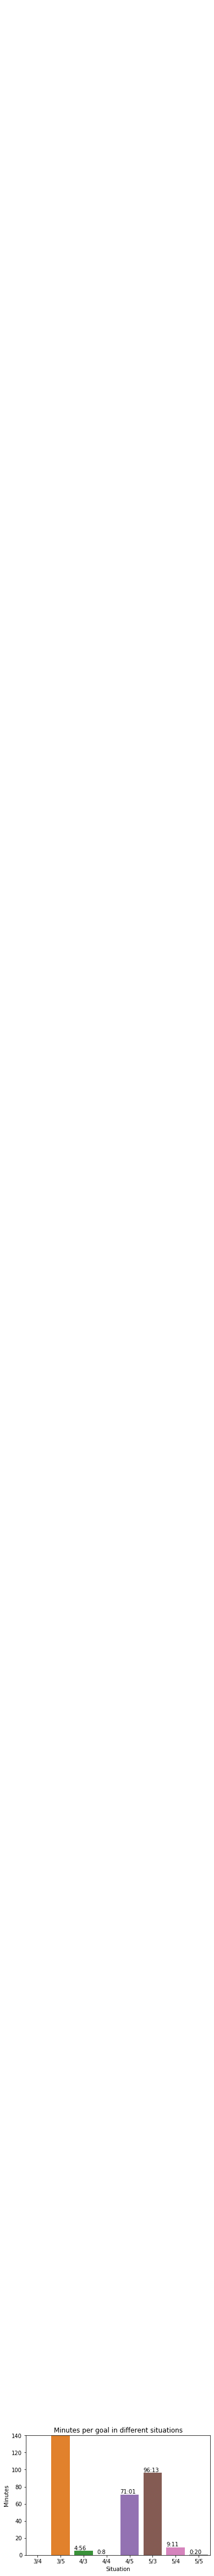

In [80]:
ax = sns.barplot(y="goal", x="strength", data=shotpivot_minspergoal.reset_index());
ax.set_xlabel("Situation")
ax.set_ylabel("Minutes")
ax.set_title("Minutes per goal in different situations")
ind = 0
for p in ax.patches:
    ax.annotate(minspergoal[ind][0], (p.get_x() * 1-0.01, p.get_height() + 1))
    ind +=1
ax.set_ylim(0,140);

In [81]:
shotpivot

shot_outcome,blocked,goal,saved,wide
strength,,,,
3/4,NaN,NaN,2.0,NaN
3/5,NaN,1.0,6.0,5.0
4/3,4.0,2.0,12.0,11.0
4/4,39.0,29.0,125.0,59.0
4/5,82.0,42.0,436.0,138.0
5/3,34.0,31.0,150.0,58.0
5/4,878.0,325.0,2417.0,1149.0
5/5,3020.0,986.0,10580.0,4320.0


Now we can combine the last two plots to generate shot type probabilities as a function of distance and as a function of game situation.

In [82]:
# Shot Distance Histogram bin width:
binwidth=1
# Let's look at shots excluding ENGs and Penalty shots, separated by rebound, PP, SH, even handed.
# We'll also exclude over time where we have 3-on-3.
inds_noteng = all_shot_df.loc[:,"isENG"] ==False
inds_notps = all_shot_df.loc[:,"isPS"] ==False
inds_regtime = all_shot_df.loc[:,"period"] <4
inds_normal = (all_shot_df.loc[:,"is_saved_rebound"] ==False)&inds_noteng&inds_notps&inds_regtime
inds_reb = (all_shot_df.loc[:,"is_saved_rebound"] ==True)&inds_noteng&inds_notps&inds_regtime
inds_even = (
    (all_shot_df.loc[:,"strength"] =="5/5")|
    (all_shot_df.loc[:,"strength"] =="4/4")|
    (all_shot_df.loc[:,"strength"] =="3/3")
)&inds_noteng&inds_notps&inds_regtime
inds_PP = (
    (all_shot_df.loc[:,"strength"] =="5/4")|
    (all_shot_df.loc[:,"strength"] =="4/3")|
    (all_shot_df.loc[:,"strength"] =="5/3")
)&inds_noteng&inds_notps&inds_regtime
inds_SH = (
    (all_shot_df.loc[:,"strength"] =="4/5")|
    (all_shot_df.loc[:,"strength"] =="3/4")|
    (all_shot_df.loc[:,"strength"] =="3/5")
)&inds_noteng&inds_notps&inds_regtime
all_shot_df.loc[inds_even,"short_even_pp"] = "ev"
all_shot_df.loc[inds_PP,"short_even_pp"] = "pp"
all_shot_df.loc[inds_SH,"short_even_pp"] = "sh"
inds_goal = (all_shot_df.loc[:,"shot_outcome"] == "goal")&inds_noteng&inds_notps&inds_regtime
inds_saved = (all_shot_df.loc[:,"shot_outcome"] == "saved")&inds_noteng&inds_notps&inds_regtime
inds_wide = (all_shot_df.loc[:,"shot_outcome"] == "wide")&inds_noteng&inds_notps&inds_regtime
inds_blocked = (all_shot_df.loc[:,"shot_outcome"] == "blocked")&inds_noteng&inds_notps&inds_regtime

n_total = sum(inds_noteng&inds_notps&inds_regtime)
n_goal = sum(inds_goal)
n_saved = sum(inds_saved)
n_wide = sum(inds_wide)
n_blocked = sum(inds_blocked)
h_total,x_total = np.histogram(
    all_shot_df.loc[
        inds_noteng&inds_notps&inds_regtime,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal,_ = np.histogram(
    all_shot_df.loc[
        inds_goal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved,_ = np.histogram(
    all_shot_df.loc[
        inds_saved,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide,_ = np.histogram(
    all_shot_df.loc[
        inds_wide,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)

n_total_PP = sum(inds_PP)
n_goal_PP = sum(inds_goal&inds_PP)
n_saved_PP = sum(inds_saved&inds_PP)
n_wide_PP = sum(inds_wide&inds_PP)
n_blocked_PP = sum(inds_blocked&inds_PP)
h_total_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_SH = sum(inds_SH)
n_goal_SH = sum(inds_goal&inds_SH)
n_saved_SH = sum(inds_saved&inds_SH)
n_wide_SH = sum(inds_wide&inds_SH)
n_blocked_SH = sum(inds_blocked&inds_SH)
h_total_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_even = sum(inds_even)
n_goal_even = sum(inds_goal&inds_even)
n_saved_even = sum(inds_saved&inds_even)
n_wide_even = sum(inds_wide&inds_even)
n_blocked_even = sum(inds_blocked&inds_even)
h_total_even,_ = np.histogram(
    all_shot_df.loc[
        inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_even,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_even,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_even,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)


n_total_normal = sum(inds_normal)
n_goal_normal = sum(inds_normal&inds_goal)
n_saved_normal = sum(inds_normal&inds_saved)
n_wide_normal = sum(inds_normal&inds_wide)
n_blocked_normal = sum(inds_normal&inds_blocked)
h_total_normal,_ = np.histogram(
    all_shot_df.loc[
        inds_normal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_normal,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_normal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_normal,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_normal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_normal,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_normal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_normal,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_normal,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_reb = sum(inds_reb)
n_goal_reb = sum(inds_reb&inds_goal)
n_saved_reb = sum(inds_reb&inds_saved)
n_wide_reb = sum(inds_reb&inds_wide)
n_blocked_reb = sum(inds_reb&inds_blocked)
h_total_reb,_ = np.histogram(
    all_shot_df.loc[
        inds_reb,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_reb,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_reb,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_reb,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_reb,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_reb,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_reb,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_reb,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_reb,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)

n_total_normal_PP = sum(inds_normal&inds_PP)
n_goal_normal_PP = sum(inds_normal&inds_goal&inds_PP)
n_saved_normal_PP = sum(inds_normal&inds_saved&inds_PP)
n_wide_normal_PP = sum(inds_normal&inds_wide&inds_PP)
n_blocked_normal_PP = sum(inds_normal&inds_blocked&inds_PP)
h_total_normal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_normal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_normal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_normal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_normal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_normal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_normal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_normal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_normal_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_normal&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_reb_PP = sum(inds_reb&inds_PP)
n_goal_reb_PP = sum(inds_reb&inds_goal&inds_PP)
n_saved_reb_PP = sum(inds_reb&inds_saved&inds_PP)
n_wide_reb_PP = sum(inds_reb&inds_wide&inds_PP)
n_blocked_reb_PP = sum(inds_reb&inds_blocked&inds_PP)
h_total_reb_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_reb&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_reb_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_reb&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_reb_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_reb&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_reb_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_reb&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_reb_PP,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_reb&inds_PP,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)

n_total_normal_even = sum(inds_normal&inds_even)
n_goal_normal_even = sum(inds_normal&inds_goal&inds_even)
n_saved_normal_even = sum(inds_normal&inds_saved&inds_even)
n_wide_normal_even = sum(inds_normal&inds_wide&inds_even)
n_blocked_normal_even = sum(inds_normal&inds_blocked&inds_even)
h_total_normal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_normal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_normal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_normal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_normal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_normal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_normal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_normal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_normal_even,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_normal&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_reb_even = sum(inds_reb&inds_even)
n_goal_reb_even = sum(inds_reb&inds_goal&inds_even)
n_saved_reb_even = sum(inds_reb&inds_saved&inds_even)
n_wide_reb_even = sum(inds_reb&inds_wide&inds_even)
n_blocked_reb_even = sum(inds_reb&inds_blocked&inds_even)
h_total_reb_even,_ = np.histogram(
    all_shot_df.loc[
        inds_reb&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_reb_even,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_reb&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_reb_even,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_reb&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_reb_even,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_reb&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_reb_even,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_reb&inds_even,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)

n_total_normal_SH = sum(inds_normal&inds_SH)
n_goal_normal_SH = sum(inds_normal&inds_goal&inds_SH)
n_saved_normal_SH = sum(inds_normal&inds_saved&inds_SH)
n_wide_normal_SH = sum(inds_normal&inds_wide&inds_SH)
n_blocked_normal_SH = sum(inds_normal&inds_blocked&inds_SH)
h_total_normal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_normal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_normal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_normal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_normal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_normal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_normal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_normal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_normal_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_normal&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
n_total_reb_SH = sum(inds_reb&inds_SH)
n_goal_reb_SH = sum(inds_reb&inds_goal&inds_SH)
n_saved_reb_SH = sum(inds_reb&inds_saved&inds_SH)
n_wide_reb_SH = sum(inds_reb&inds_wide&inds_SH)
n_blocked_reb_SH = sum(inds_reb&inds_blocked&inds_SH)
h_total_reb_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_reb&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_goal_reb_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&inds_reb&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_saved_reb_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_saved&inds_reb&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_wide_reb_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_wide&inds_reb&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)
h_blocked_reb_SH,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked&inds_reb&inds_SH,"shotdistance_m"
    ],
    bins=np.arange(0,60,binwidth)
)

In [83]:
print("All Goal Proportions:")
print("Even Strength: {:.1%}".format(n_goal_even/n_total_even))
print("Shorthanded: {:.1%}".format(n_goal_SH/n_total_SH))
print("Powerplay: {:.1%}".format(n_goal_PP/n_total_PP))

print("Non-rebound Goal Proportions:")
print("Even Strength: {:.1%}".format(n_goal_normal_even/n_total_normal_even))
print("Shorthanded: {:.1%}".format(n_goal_normal_SH/n_total_normal_SH))
print("Powerplay: {:.1%}".format(n_goal_normal_PP/n_total_normal_PP))

print("Rebound Goal Proportions:")
print("Even Strength: {:.1%}".format(n_goal_reb_even/n_total_reb_even))
print("Shorthanded: {:.1%}".format(n_goal_reb_SH/n_total_reb_SH))
print("Powerplay: {:.1%}".format(n_goal_reb_PP/n_total_reb_PP))

print("Total Rebound Goals Even Strength: " + str(n_goal_reb_even))
print("Total Rebound Goals Shorthanded: " + str(n_goal_reb_SH))
print("Total Rebound Goals Powerplay: " + str(n_goal_reb_PP))

print("Total Non-Rebound Goals Even Strength: " + str(n_goal_normal_even))
print("Total Non-Rebound Goals Shorthanded: " + str(n_goal_normal_SH))
print("Total Non-Rebound Goals Powerplay: " + str(n_goal_normal_PP))


All Goal Proportions:
Even Strength: 5.3%
Shorthanded: 6.1%
Powerplay: 7.1%
Non-rebound Goal Proportions:
Even Strength: 5.1%
Shorthanded: 5.9%
Powerplay: 6.5%
Rebound Goal Proportions:
Even Strength: 14.7%
Shorthanded: 10.5%
Powerplay: 27.5%
Total Rebound Goals Even Strength: 57
Total Rebound Goals Shorthanded: 2
Total Rebound Goals Powerplay: 39
Total Non-Rebound Goals Even Strength: 958
Total Non-Rebound Goals Shorthanded: 41
Total Non-Rebound Goals Powerplay: 319


In [84]:
print("Non-Rebounds All Strengths Proportions:")
print("Goal: {:.1%}".format(n_goal_normal/n_total_normal))
print("Saved: {:.1%}".format(n_saved_normal/n_total_normal))
print("Blocked: {:.1%}".format(n_blocked_normal/n_total_normal))
print("Wide: {:.1%}".format(n_wide_normal/n_total_normal))

print("Rebounds All Strengths Proportions:")
print("Goal: {:.1%}".format(n_goal_reb/n_total_reb))
print("Saved: {:.1%}".format(n_saved_reb/n_total_reb))
print("Blocked: {:.1%}".format(n_blocked_reb/n_total_reb))
print("Wide: {:.1%}".format(n_wide_reb/n_total_reb))


Non-Rebounds All Strengths Proportions:
Goal: 5.4%
Saved: 55.1%
Blocked: 16.4%
Wide: 23.1%
Rebounds All Strengths Proportions:
Goal: 17.9%
Saved: 53.7%
Blocked: 9.8%
Wide: 18.6%


/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


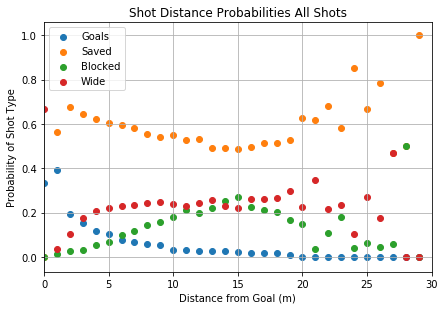

In [85]:
plt.scatter(x_total[:-1],h_goal/h_total,label="Goals")
plt.scatter(x_total[:-1],h_saved/h_total,label="Saved")
plt.scatter(x_total[:-1],h_blocked/h_total,label="Blocked")
plt.scatter(x_total[:-1],h_wide/h_total,label="Wide")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Distance from Goal (m)")
plt.ylabel("Probability of Shot Type")

plt.title("Shot Distance Probabilities All Shots");

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


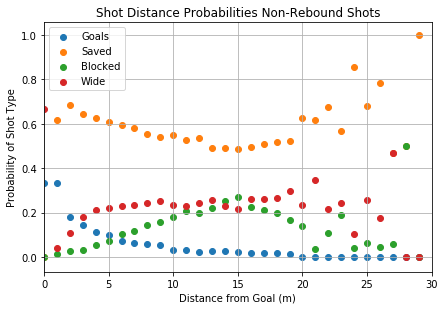

In [86]:
plt.scatter(x_total[:-1],h_goal_normal/h_total_normal,label="Goals")
plt.scatter(x_total[:-1],h_saved_normal/h_total_normal,label="Saved")
plt.scatter(x_total[:-1],h_blocked_normal/h_total_normal,label="Blocked")
plt.scatter(x_total[:-1],h_wide_normal/h_total_normal,label="Wide")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Distance from Goal (m)")
plt.ylabel("Probability of Shot Type")

plt.title("Shot Distance Probabilities Non-Rebound Shots");

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


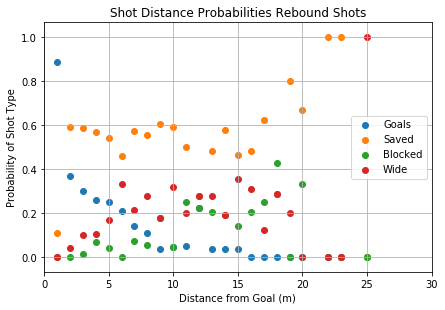

In [87]:
plt.scatter(x_total[:-1],h_goal_reb/h_total_reb,label="Goals")
plt.scatter(x_total[:-1],h_saved_reb/h_total_reb,label="Saved")
plt.scatter(x_total[:-1],h_blocked_reb/h_total_reb,label="Blocked")
plt.scatter(x_total[:-1],h_wide_reb/h_total_reb,label="Wide")
plt.grid(b=True,axis="y",which="major")
plt.grid(b=True,axis="x",which="major")
plt.tight_layout()
plt.legend()
plt.xlim(0,30)
plt.xlabel("Distance from Goal (m)")
plt.ylabel("Probability of Shot Type")

plt.title("Shot Distance Probabilities Rebound Shots");

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value e

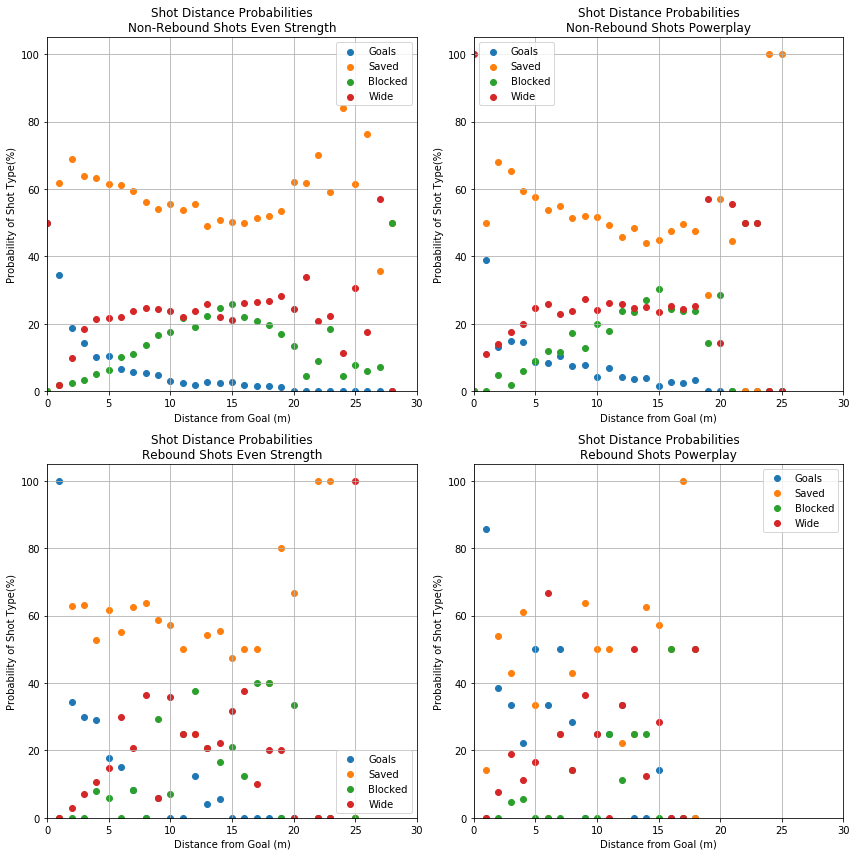

In [88]:
f, axs = plt.subplots(2,2,figsize=(12, 12))
axs[0,0].scatter(x_total[:-1],100*h_goal_normal_even/h_total_normal_even,label="Goals")
axs[0,0].scatter(x_total[:-1],100*h_saved_normal_even/h_total_normal_even,label="Saved")
axs[0,0].scatter(x_total[:-1],100*h_blocked_normal_even/h_total_normal_even,label="Blocked")
axs[0,0].scatter(x_total[:-1],100*h_wide_normal_even/h_total_normal_even,label="Wide")
axs[0,0].grid(b=True,axis="y",which="major")
axs[0,0].grid(b=True,axis="x",which="major")
axs[0,0].legend()
axs[0,0].set_xlim(0,30)
axs[0,0].set_ylim(0,105)
axs[0,0].set_xlabel("Distance from Goal (m)")
axs[0,0].set_ylabel("Probability of Shot Type(%)")
axs[0,0].set_title("Shot Distance Probabilities\nNon-Rebound Shots Even Strength");

axs[0,1].scatter(x_total[:-1],100*h_goal_normal_PP/h_total_normal_PP,label="Goals")
axs[0,1].scatter(x_total[:-1],100*h_saved_normal_PP/h_total_normal_PP,label="Saved")
axs[0,1].scatter(x_total[:-1],100*h_blocked_normal_PP/h_total_normal_PP,label="Blocked")
axs[0,1].scatter(x_total[:-1],100*h_wide_normal_PP/h_total_normal_PP,label="Wide")
axs[0,1].grid(b=True,axis="y",which="major")
axs[0,1].grid(b=True,axis="x",which="major")
axs[0,1].legend()
axs[0,1].set_xlim(0,30)
axs[0,1].set_ylim(0,105)
axs[0,1].set_xlabel("Distance from Goal (m)")
axs[0,1].set_ylabel("Probability of Shot Type(%)")
axs[0,1].set_title("Shot Distance Probabilities\nNon-Rebound Shots Powerplay");

axs[1,0].scatter(x_total[:-1],100*h_goal_reb_even/h_total_reb_even,label="Goals")
axs[1,0].scatter(x_total[:-1],100*h_saved_reb_even/h_total_reb_even,label="Saved")
axs[1,0].scatter(x_total[:-1],100*h_blocked_reb_even/h_total_reb_even,label="Blocked")
axs[1,0].scatter(x_total[:-1],100*h_wide_reb_even/h_total_reb_even,label="Wide")
axs[1,0].grid(b=True,axis="y",which="major")
axs[1,0].grid(b=True,axis="x",which="major")
axs[1,0].legend()
axs[1,0].set_xlim(0,30)
axs[1,0].set_ylim(0,105)
axs[1,0].set_xlabel("Distance from Goal (m)")
axs[1,0].set_ylabel("Probability of Shot Type(%)")
axs[1,0].set_title("Shot Distance Probabilities\nRebound Shots Even Strength");

axs[1,1].scatter(x_total[:-1],100*h_goal_reb_PP/h_total_reb_PP,label="Goals")
axs[1,1].scatter(x_total[:-1],100*h_saved_reb_PP/h_total_reb_PP,label="Saved")
axs[1,1].scatter(x_total[:-1],100*h_blocked_reb_PP/h_total_reb_PP,label="Blocked")
axs[1,1].scatter(x_total[:-1],100*h_wide_reb_PP/h_total_reb_PP,label="Wide")
axs[1,1].grid(b=True,axis="y",which="major")
axs[1,1].grid(b=True,axis="x",which="major")
axs[1,1].legend()
axs[1,1].set_xlim(0,30)
axs[1,1].set_ylim(0,105)
axs[1,1].set_xlabel("Distance from Goal (m)")
axs[1,1].set_ylabel("Probability of Shot Type(%)")
axs[1,1].set_title("Shot Distance Probabilities\nRebound Shots Powerplay");


plt.tight_layout()

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipyke

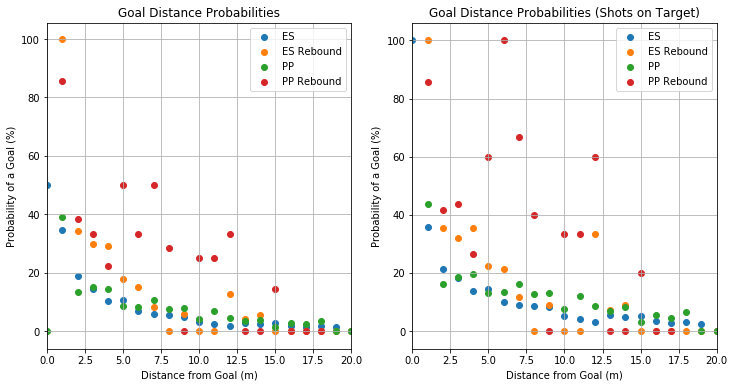

In [89]:
f, axs = plt.subplots(1,2,figsize=(12, 6))
axs[0].scatter(x_total[:-1],100.*h_goal_normal_even/(h_total_normal_even),label="ES")
axs[0].scatter(x_total[:-1],100.*h_goal_reb_even/(h_total_reb_even),label="ES Rebound")
axs[0].scatter(x_total[:-1],100.*h_goal_normal_PP/(h_total_normal_PP),label="PP")
axs[0].scatter(x_total[:-1],100.*h_goal_reb_PP/(h_total_reb_PP),label="PP Rebound")
axs[0].grid(b=True,axis="y",which="major")
axs[0].grid(b=True,axis="x",which="major")
axs[0].legend()
axs[0].set_xlim(0,20)
axs[0].set_xlabel("Distance from Goal (m)")
axs[0].set_ylabel("Probability of a Goal (%)")
axs[0].set_title("Goal Distance Probabilities");

axs[1].scatter(x_total[:-1],100.*h_goal_normal_even/(h_goal_normal_even+h_saved_normal_even),label="ES")
axs[1].scatter(x_total[:-1],100.*h_goal_reb_even/(h_goal_reb_even+h_saved_reb_even),label="ES Rebound")
axs[1].scatter(x_total[:-1],100.*h_goal_normal_PP/(h_goal_normal_PP+h_saved_normal_PP),label="PP")
axs[1].scatter(x_total[:-1],100.*h_goal_reb_PP/(h_goal_reb_PP+h_saved_reb_PP),label="PP Rebound")
axs[1].grid(b=True,axis="y",which="major")
axs[1].grid(b=True,axis="x",which="major")
axs[1].legend()
axs[1].set_xlim(0,20)
axs[1].set_xlabel("Distance from Goal (m)")
axs[1].set_ylabel("Probability of a Goal (%)")
axs[1].set_title("Goal Distance Probabilities (Shots on Target)");

### Shot Angle

Finally, let's look at the angular distribution of the shots.

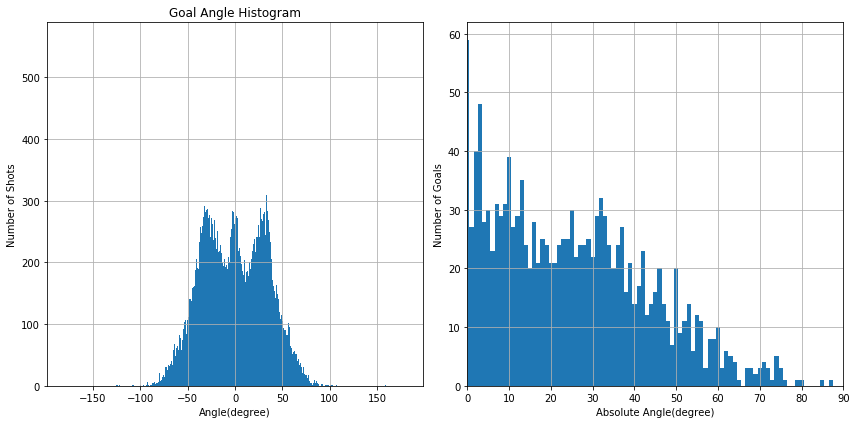

In [90]:
f, axs = plt.subplots(1,2,figsize=(12, 6))
axs[0].hist(all_shot_df.loc[:,"shotangle_deg"],bins=np.arange(-180.5,181.5,1));
axs[0].grid(b=True,axis="y",which="major")
axs[0].grid(b=True,axis="x",which="major")
#axs[0].tight_layout()
# axs[0].legend()
# axs[0].set_xlim(0,90)
# axs[0].set_ylim(0,200)
axs[0].set_xlabel("Angle(degree)")
axs[0].set_ylabel("Number of Shots")
axs[0].set_title("Shot Angle Histogram");
axs[1].hist(np.abs(all_shot_df.loc[inds_goal,"shotangle_deg"]),bins=np.arange(-180.5,181.5,1));
axs[1].grid(b=True,axis="y",which="major")
axs[1].grid(b=True,axis="x",which="major")

# axs[1].legend()
axs[1].set_xlim(0,90)
# axs[1].set_ylim(0,20)
axs[1].set_xlabel("Absolute Angle(degree)")
axs[1].set_ylabel("Number of Goals");
axs[0].set_title("Goal Angle Histogram");
plt.tight_layout()

In [91]:
ang_binwidth = 1
h_total_ang,x_total_ang = np.histogram(
    all_shot_df.loc[
        inds_noteng&
        inds_notps&
        inds_regtime,
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)
h_goal_ang,_ = np.histogram(
    all_shot_df.loc[
        inds_goal,
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)

h_goal_ang_lw,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&
        (all_shot_df.loc[:,"shotangle_deg"]<0),
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)

h_goal_ang_rw,_ = np.histogram(
    all_shot_df.loc[
        inds_goal&
        (all_shot_df.loc[:,"shotangle_deg"]>0),
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)


h_saved_ang,_ = np.histogram(
    all_shot_df.loc[
        inds_saved,
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)
h_wide_ang,_ = np.histogram(
    all_shot_df.loc[
        inds_wide,
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)
h_blocked_ang,_ = np.histogram(
    all_shot_df.loc[
        inds_blocked,
        "shotangle_deg"
    ],
    bins=np.arange(-180,181,ang_binwidth)
)

/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/ncalvertuk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in

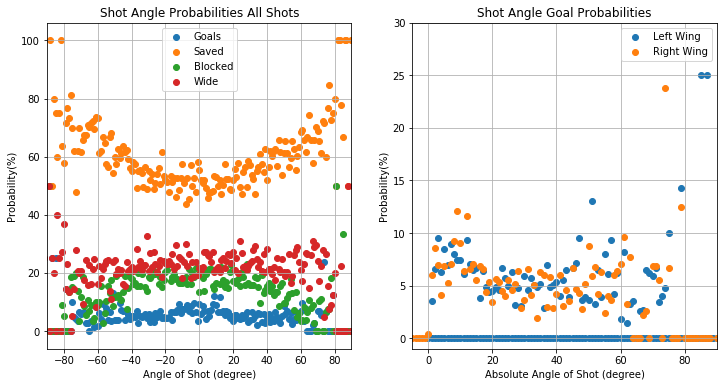

In [92]:
f, axs = plt.subplots(1,2,figsize=(12, 6))
axs[0].scatter(x_total_ang[:-1],100.*h_goal_ang/h_total_ang,label="Goals")
axs[0].scatter(x_total_ang[:-1],100.*h_saved_ang/h_total_ang,label="Saved")
axs[0].scatter(x_total_ang[:-1],100.*h_blocked_ang/h_total_ang,label="Blocked")
axs[0].scatter(x_total_ang[:-1],100.*h_wide_ang/h_total_ang,label="Wide")
axs[0].grid(b=True,axis="y",which="major")
axs[0].grid(b=True,axis="x",which="major")
#axs[0].tight_layout()
axs[0].legend()
axs[0].set_xlim(-90,90)
axs[0].set_xlabel("Angle of Shot (degree)")
axs[0].set_ylabel("Probability(%)")

axs[1].set_title("Shot Angle Goal Probabilities");

axs[1].scatter(np.abs(x_total_ang[:-1]),100.*h_goal_ang_lw/h_total_ang,label="Left Wing")
axs[1].scatter(x_total_ang[:-1],100.*h_goal_ang_rw/h_total_ang,label="Right Wing")
axs[1].grid(b=True,axis="y",which="major")
axs[1].grid(b=True,axis="x",which="major")
#axs[0].tight_layout()
axs[1].legend()
axs[1].set_xlim(-5,90)
axs[1].set_ylim(-1,30)
axs[1].set_xlabel("Absolute Angle of Shot (degree)")
axs[1].set_ylabel("Probability(%)")

axs[0].set_title("Shot Angle Probabilities All Shots");

### Shot Quality Model: Logistic Regression

We can build a shot quality model to predict the probability each shot results in a goal or not. We'll use Logistic Regression and a Random Forest to build 2 models. I'll be using all shot attempts for this, rather than just saves & shots. 

I'll be using 4 predictor variables: Shot Angle, (Adjusted) Shot Distance, Situation (EV,PP,SH), and Rebound (True or False).

The adjusted shot distance will be calculated by subtracting the mean shot distance in that rink from the recorded shot distance - this is to account for rink-by-rink variations in recorded shot distance. We'll calculate this first before training our models.

In [93]:
avgshotdist = all_shot_df.groupby(["rink"])[["shotdistance_m"]].mean()

for rink in avgshotdist.index:
    inds = all_shot_df.loc[:,"rink"] == rink
    all_shot_df.loc[inds,"adjdistance_m"] = all_shot_df.loc[inds,"shotdistance_m"] - avgshotdist.loc[rink,:].values[0]


In [94]:
all_shot_df.columns

Index(['id', 'player_id', 'jersey', 'first_name', 'last_name', 'team_id',
       'match_shot_resutl_id', 'time', 'coordinate_x', 'coordinate_y',
       'real_date', 'home_game', 'team_name', 'opposition_id',
       'opposition_name', 'match_id', 'shot_outcome', 'year', 'month', 'day',
       'fullname', 'period', 'shotdistance', 'goal', 'corrected_x',
       'corrected_y', 'match_length', 'rink_w', 'rink_l', 'rink', 'x_m', 'y_m',
       'goal_x_m', 'goal_y_m', 'shotdistance_m', 'shotangle_deg',
       'time_to_prior_save', 'time_to_next_shot', 'time_to_prior_shot',
       'leads_to_rebound', 'is_rebound', 'is_saved_rebound', 'HomePlayers',
       'AwayPlayers', 'isPS', 'allgoaldfindex', 'isDPG', 'isENG', 'strength',
       'short_even_pp', 'adjdistance_m'],
      dtype='object')

We can create our sub-DataFrame, which contains only the variables we're interested in. I also filter out Empty net goals, Penalty shots, and over time period shots.

In [95]:
# feats = ["shotangle_deg","shotdistance_m","short_even_pp","is_saved_rebound"]
feats = ["shotangle_deg","adjdistance_m","short_even_pp","is_saved_rebound"]
labs = "goal"
df_sub = all_shot_df.loc[
    (all_shot_df.loc[:,"isENG"]==False)&
    (all_shot_df.loc[:,"isPS"]==False)&
    (all_shot_df.loc[:,"period"]<4)&
    (all_shot_df.loc[:,"strength"] != "PS"),
    feats+[labs]
]
df_sub["short_even_pp"] = df_sub["short_even_pp"].astype("category").cat.codes
df_sub["goal"] = df_sub["goal"].astype("category").cat.codes
df_sub["is_saved_rebound"] = df_sub["is_saved_rebound"].astype("category").cat.codes

df_sub.loc[:,"shotangle_deg"] = np.abs(df_sub.loc[:,"shotangle_deg"])

We'll normalise the numeric variables.

In [96]:
X = df_sub.loc[:,feats].to_numpy()
y = df_sub.loc[:,labs].to_numpy()
ct = ColumnTransformer(
    [("standard", StandardScaler(), [0, 1]),
     ("none", "passthrough", [2, 3])
    ])

Before evaluating the model we'll define the Kolmogorov Smirnov statistic which will be one of the metrics used.

In [97]:
def KScalc(y_pred,y_test):
    ngoals_test = sum(y_test ==1)
    nsaves_test = sum(y_test ==0)
    p0 = [y[0] for y in y_pred]
    deciles = np.append(0,[np.percentile(p0, i, axis=0) for i in range(10,110,10)])
    goals_pred = np.array([])
    saves_pred = np.array([])
    ntotal = np.array([])
    for i in range(0,len(deciles)-1):
        lower = deciles[i]
        upper = deciles[i+1]
        inds = (p0 >=lower) & (p0<upper)
        goals_pred = np.append(goals_pred,sum(y_test[inds]==1))
        saves_pred = np.append(saves_pred,sum(y_test[inds]==0))
        ntotal = np.append(ntotal,sum(inds))
    cumul_saves = np.cumsum(saves_pred/nsaves_test)
    cumul_goals = np.cumsum(goals_pred/ngoals_test)
    int_saves = saves_pred/(saves_pred+goals_pred)
    int_goals = goals_pred/(saves_pred+goals_pred)
    return 100*np.amax(cumul_goals - cumul_saves)

Evaluate the Logistic Regression model using Repeated Stratified K-fold CV.

In [98]:
model = LogisticRegression(
    penalty ="l2",
    solver = "liblinear",
    class_weight=None,
    fit_intercept = True,
    max_iter=1000
)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
auc = np.array([])
ks = np.array([])
for train_index, test_index in cv.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    X_train = ct.fit_transform(X_train);
    X_test = ct.transform(X_test);
    model.fit(X_train, y_train);
    y_hat = model.predict_proba(X_test)
    auc = np.append(auc,roc_auc_score(y_test,[y[1] for y in y_hat]))
    ks = np.append(ks,KScalc(y_hat,y_test))

Print out the mean values of the metrics and the 95% CI, followed by the feature importance calculated by the model

In [99]:
print(np.around(np.mean(ks),0),np.around(np.std(ks)*1.96,0))
print(np.around(np.mean(auc),2),np.around(np.std(auc)*1.96,2))

37.0 7.0
0.74 0.05


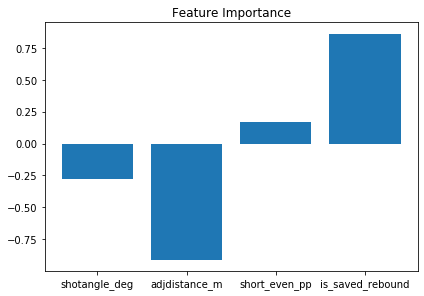

Intercept: -3.22868
AUC : 0.74


<Figure size 432x288 with 0 Axes>

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.1)
X_train = ct.fit_transform(X_train);
X_test = ct.transform(X_test);
model.fit(X_train, y_train);
y_hat = model.predict_proba(X_test)
auc_test = roc_auc_score(y_test,[y[1] for y in y_hat])
featimportance = model.coef_[0]
bias = model.intercept_[0]
plt.bar([x for x in range(len(featimportance))], featimportance);
plt.xticks([0,1,2,3],labels = feats);
plt.tight_layout();
plt.title("Feature Importance");
plt.show();
print("Intercept: %.5f" % (bias));
print("AUC : %.2f" % auc_test)
plt.tight_layout();

As I used Logistic Regression we have to take the exponential of the coefficients to calculate the effect on the odds ratio caused by a unit increase in each of the variables (assuming the others stay constant).

In [101]:
np.exp(featimportance)

array([0.75459076, 0.40297771, 1.18170771, 2.36383903])

We can apply the model to the entire dataset and calculate the probability that each shot results in a goal.

In [102]:
X_all = ct.transform(X);
y_all = model.predict_proba(X_all)
p_goal = [y[1] for y in y_all]
np.mean(p_goal)

0.05697517815476894

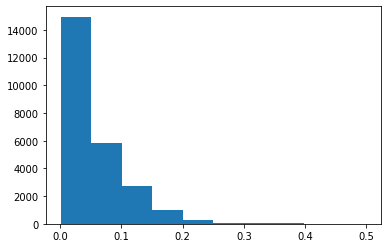

In [103]:
plt.hist(p_goal);

### Shot Quality Model: Random Forest

Let's also try a Random Forest. We now a larger number of hyperparameters that need to be optimised, which I've done using a Randomised Search

In [104]:
n_estimators = [500,800,1500,2500,5000]
max_features =["auto","sqrt","log2"]
max_depth = [10,20,30,40,50]
max_depth.append(None)
min_samples_split = [2,5,10,15,20]
min_samples_leaf=[1,2,5,10,15]
grid_param = {
    "rf__n_estimators":n_estimators,
    "rf__max_features":max_features,
    "rf__max_depth":max_depth,
    "rf__min_samples_split":min_samples_split,
    "rf__min_samples_leaf":min_samples_leaf
}

rfmodel = RandomForestClassifier(random_state=0)
pipeforest = Pipeline([("coltransformer",ct),("rf",rfmodel)])
rf_srch = RandomizedSearchCV(
    estimator = pipeforest,
    param_distributions=grid_param,
    n_iter=20,
    cv=5,
    verbose=2,
    random_state=1,
    n_jobs=-1,
    scoring="roc_auc"
)

In [105]:
rf_srch.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 27.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('coltransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('standard',
                                                                               StandardScaler(copy=True,
                                                                                              with_mean=True,
                                                                                              with_std=True),
                                                                               [0,
         

In [106]:
print(rf_srch.best_params_)

{'rf__n_estimators': 1500, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 15, 'rf__max_features': 'log2', 'rf__max_depth': 10}


In [107]:
# define evaluation procedure
rfmodelopt = RandomForestClassifier(
    random_state=0,
    n_estimators=1500,
    min_samples_split=5,
    min_samples_leaf=15,
    max_features="log2",
    max_depth=10,
    n_jobs=-1
)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
rfauc = np.array([])
rfks = np.array([])
for train_index, test_index in cv.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    X_train = ct.fit_transform(X_train);
    X_test = ct.transform(X_test);
    rfmodelopt.fit(X_train, y_train);
    y_hat = rfmodelopt.predict_proba(X_test)
    rfauc = np.append(rfauc,roc_auc_score(y_test,[y[1] for y in y_hat]))
    rfks = np.append(rfks,KScalc(y_hat,y_test))

In [108]:
print(np.around(np.mean(rfks),0),np.around(np.std(rfks)*1.96,0))
print(np.around(np.mean(rfauc),2),np.around(np.std(rfauc)*1.96,2))

36.0 7.0
0.73 0.05


In [109]:
feats,rfmodelopt.feature_importances_

(['shotangle_deg', 'adjdistance_m', 'short_even_pp', 'is_saved_rebound'],
 array([0.29779472, 0.62178176, 0.02856107, 0.05186244]))

### Shot Quality

We can use our model to generate the probability that a shot resulted in a goal anywhere on the ice under any circumstances. First we'll define a grid of points on the ice.

In [110]:
# xx, yy = np.mgrid[-15:16,0:31]
xx, yy = np.mgrid[-15:16:0.1,0:31:0.1]
i = 0
goal_x_m = goaly*rinklengths[i]/200.
goal_y_m = goalx*rinkwidths[i]/200.
dists = np.sqrt(np.power(goal_x_m-yy,2)+np.power(goal_y_m-xx,2))
angs = np.arctan2(goal_y_m-xx,goal_x_m-yy)*180/np.pi
X_grid=np.zeros([len(np.abs(angs).ravel()),4])
X_grid[:,0] = (np.abs(angs).ravel());
X_grid[:,1] = dists.ravel();
X_grid[:,2] = 0
X_grid[:,3] = 0
X_grid_pp = np.zeros([len(np.abs(angs).ravel()),4])
X_grid_pp[:,0] = (np.abs(angs).ravel());
X_grid_pp[:,1] = dists.ravel();
X_grid_pp[:,2] = 1
X_grid_pp[:,3] = 0
X_grid_sh = np.zeros([len(np.abs(angs).ravel()),4])
X_grid_sh[:,0] = (np.abs(angs).ravel());
X_grid_sh[:,1] = dists.ravel();
X_grid_sh[:,2] = 2
X_grid_sh[:,3] = 0
X_grid_reb = np.zeros([len(np.abs(angs).ravel()),4])
X_grid_reb[:,0] = (np.abs(angs).ravel());
X_grid_reb[:,1] = dists.ravel();
X_grid_reb[:,2] = 0
X_grid_reb[:,3] = 1
X_grid_pp_reb = np.zeros([len(np.abs(angs).ravel()),4])
X_grid_pp_reb[:,0] = (np.abs(angs).ravel());
X_grid_pp_reb[:,1] = dists.ravel();
X_grid_pp_reb[:,2] = 1
X_grid_pp_reb[:,3] = 1
X_grid_sh_reb = np.zeros([len(np.abs(angs).ravel()),4])
X_grid_sh_reb[:,0] = (np.abs(angs).ravel());
X_grid_sh_reb[:,1] = dists.ravel();
X_grid_sh_reb[:,2] = 2
X_grid_sh_reb[:,3] = 1

inds = [True, True, False, True, True, True, True, False, True, True]
X_grid[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_pp[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_sh[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_reb[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_pp_reb[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_sh_reb[:,1] = X_grid[:,1]- avgshotdist.loc[inds].median().values[0]
X_grid_tr = ct.transform(X_grid);
X_grid_pp_tr = ct.transform(X_grid_pp);
X_grid_sh_tr = ct.transform(X_grid_sh);
X_grid_reb_tr = ct.transform(X_grid_reb);
X_grid_pp_reb_tr = ct.transform(X_grid_pp_reb);
X_grid_sh_reb_tr = ct.transform(X_grid_sh_reb);
y_grid = rfmodelopt.predict_proba(X_grid_tr)
y_grid_pp = rfmodelopt.predict_proba(X_grid_pp_tr)
y_grid_sh = rfmodelopt.predict_proba(X_grid_sh_tr)
y_grid_reb = rfmodelopt.predict_proba(X_grid_reb_tr)
y_grid_pp_reb = rfmodelopt.predict_proba(X_grid_pp_reb_tr)
y_grid_sh_reb = rfmodelopt.predict_proba(X_grid_sh_reb_tr)
p_grid_goal_rf = [y[1] for y in y_grid]
p_grid_pp_goal_rf = [y[1] for y in y_grid_pp]
p_grid_sh_goal_rf = [y[1] for y in y_grid_sh]
p_grid_reb_goal_rf = [y[1] for y in y_grid_reb]
p_grid_pp_reb_goal_rf = [y[1] for y in y_grid_pp_reb]
p_grid_sh_reb_goal_rf = [y[1] for y in y_grid_sh_reb]

In [111]:
logregy_grid = model.predict_proba(X_grid_tr)
logregy_grid_pp = model.predict_proba(X_grid_pp_tr)
logregy_grid_sh = model.predict_proba(X_grid_sh_tr)
logregy_grid_reb = model.predict_proba(X_grid_reb_tr)
logregy_grid_pp_reb = model.predict_proba(X_grid_pp_reb_tr)
logregy_grid_sh_reb = model.predict_proba(X_grid_sh_reb_tr)
logregp_grid_goal = [y[1] for y in logregy_grid]
logregp_grid_pp_goal = [y[1] for y in logregy_grid_pp]
logregp_grid_sh_goal = [y[1] for y in logregy_grid_sh]
logregp_grid_reb_goal = [y[1] for y in logregy_grid_reb]
logregp_grid_pp_reb_goal = [y[1] for y in logregy_grid_pp_reb]
logregp_grid_sh_reb_goal = [y[1] for y in logregy_grid_sh_reb]

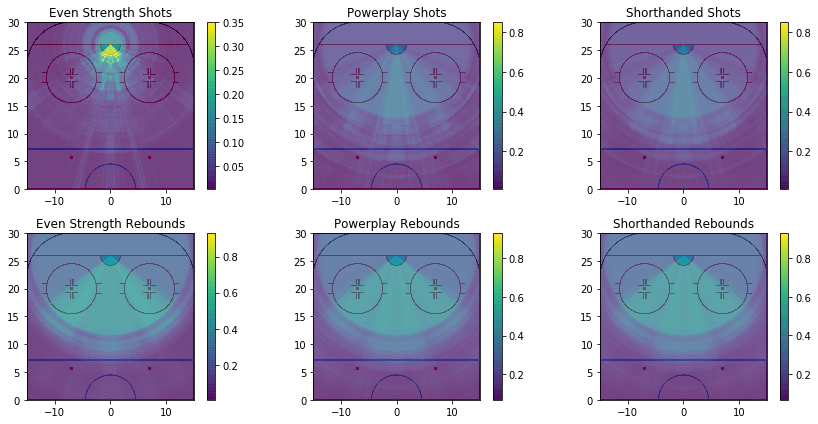

In [112]:
f, axs = plt.subplots(2,3,figsize=(12, 6))
dx = 0.05
dy = 0.05
extent = (xx[0,0]-dx, xx[-1,-1]+dx, yy[0,0]-dy, yy[-1,-1]+dy)
axs[0][0].imshow(base_image,extent = (-15,15,0,30))
a = axs[0][0].imshow(
    np.rot90(np.reshape(p_grid_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.35
)
# cs = axs[0][0].contour(xx,yy,np.reshape(p_grid_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.05))
# axs[0][0].clabel(cs, inline=1, fontsize=10)
axs[0][0].set_title("Even Strength Shots")
f.colorbar(a,ax=axs[0][0])
a = axs[0][1].imshow(base_image,extent = (-15,15,0,30))
a = axs[0][1].imshow(
    np.rot90(np.reshape(p_grid_pp_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.85
)
# cs = axs[0][1].contour(xx,yy,np.reshape(p_grid_pp_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.1))
# axs[0][1].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[0][1])
axs[0][1].set_title("Powerplay Shots")
a = axs[0][2].imshow(base_image,extent = (-15,15,0,30))
a = axs[0][2].imshow(
    np.rot90(np.reshape(p_grid_sh_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.85
)
# cs = axs[0][2].contour(xx,yy,np.reshape(p_grid_sh_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.1))
# axs[0][2].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[0][2])
axs[0][2].set_title("Shorthanded Shots")
a = axs[1][0].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][0].imshow(
    np.rot90(np.reshape(p_grid_reb_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.93
)
# cs = axs[1][0].contour(xx,yy,np.reshape(p_grid_reb_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.1))
# axs[1][0].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][0])
axs[1][0].set_title("Even Strength Rebounds")
a = axs[1][1].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][1].imshow(
    np.rot90(np.reshape(p_grid_pp_reb_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.93
)
# cs = axs[1][1].contour(xx,yy,np.reshape(p_grid_pp_reb_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.1))
# axs[1][1].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][1])
axs[1][1].set_title("Powerplay Rebounds")
a = axs[1][2].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][2].imshow(
    np.rot90(np.reshape(p_grid_sh_reb_goal_rf,np.shape(xx))),
    extent = extent,
    alpha = 0.75,
    vmax =0.93
)

# cs = axs[1][2].contour(xx,yy,np.reshape(p_grid_sh_reb_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.1))
# axs[1][2].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][2])
axs[1][2].set_title("Shorthanded Rebounds")
for a in axs:
    for b in a:
        b.set_xlim(-15,15)
        b.set_ylim(0,30)
plt.tight_layout();
plt.show()
# cs = plt.contour(xx,yy,np.reshape(p_grid_goal_rf,np.shape(xx)),levels=np.arange(0,1.1,0.05))
# plt.clabel(cs, inline=1, fontsize=10)



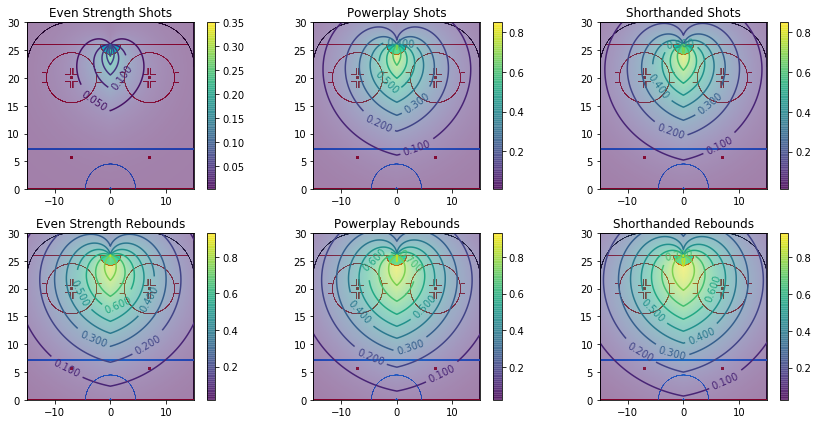

In [113]:
f, axs = plt.subplots(2,3,figsize=(12, 6))
axs[0][0].imshow(base_image,extent = (-15,15,0,30))
dx = 0.05
dy = 0.05
extent = (xx[0,0]-dx, xx[-1,-1]+dx, yy[0,0]-dy, yy[-1,-1]+dy)
a = axs[0][0].imshow(
    np.rot90(np.reshape(logregp_grid_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.35
)
cs = axs[0][0].contour(xx,yy,np.reshape(logregp_grid_goal,np.shape(xx)),levels=np.arange(0,1.1,0.05))
axs[0][0].clabel(cs, inline=1, fontsize=10)
axs[0][0].set_title("Even Strength Shots")
f.colorbar(a,ax=axs[0][0])
a = axs[0][1].imshow(base_image,extent = (-15,15,0,30))
a = axs[0][1].imshow(
    np.rot90(np.reshape(logregp_grid_pp_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.85
)
cs = axs[0][1].contour(xx,yy,np.reshape(logregp_grid_pp_goal,np.shape(xx)),levels=np.arange(0,1.1,0.1))
axs[0][1].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[0][1])
axs[0][1].set_title("Powerplay Shots")
a = axs[0][2].imshow(base_image,extent = (-15,15,0,30))
a = axs[0][2].imshow(
    np.rot90(np.reshape(logregp_grid_sh_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.85
)
cs = axs[0][2].contour(xx,yy,np.reshape(logregp_grid_sh_goal,np.shape(xx)),levels=np.arange(0,1.1,0.1))
axs[0][2].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[0][2])
axs[0][2].set_title("Shorthanded Shots")
a = axs[1][0].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][0].imshow(
    np.rot90(np.reshape(logregp_grid_reb_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.93
)
cs = axs[1][0].contour(xx,yy,np.reshape(logregp_grid_reb_goal,np.shape(xx)),levels=np.arange(0,1.1,0.1))
axs[1][0].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][0])
axs[1][0].set_title("Even Strength Rebounds")
a = axs[1][1].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][1].imshow(
    np.rot90(np.reshape(logregp_grid_pp_reb_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.93
)
cs = axs[1][1].contour(xx,yy,np.reshape(logregp_grid_pp_reb_goal,np.shape(xx)),levels=np.arange(0,1.1,0.1))
axs[1][1].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][1])
axs[1][1].set_title("Powerplay Rebounds")
a = axs[1][2].imshow(base_image,extent = (-15,15,0,30))
a = axs[1][2].imshow(
    np.rot90(np.reshape(logregp_grid_sh_reb_goal,np.shape(xx))),
    extent = extent,
    alpha = 0.5,
    vmax =0.93
)
cs = axs[1][2].contour(xx,yy,np.reshape(logregp_grid_sh_reb_goal,np.shape(xx)),levels=np.arange(0,1.1,0.1))
axs[1][2].clabel(cs, inline=1, fontsize=10)
f.colorbar(a,ax=axs[1][2])
axs[1][2].set_title("Shorthanded Rebounds")
for a in axs:
    for b in a:
        b.set_xlim(-15,15)
        b.set_ylim(0,30)
plt.tight_layout();
plt.show()

### Shot Quality for and Against

We can calculate the quality of the shots for and against each team. I had to normalised to games due to the shortened season resulting in differing number of games played by each team. The values are also normalised for the number of shots.

First, let's start with the Random Forest model, and calculate the shot quality against each team.

In [114]:
X_all = ct.transform(X);
y_allrf = rfmodelopt.predict_proba(X_all)
p_goalrf = [y[1] for y in y_allrf]
inds = ((all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"isPS"]==False)&
        (all_shot_df.loc[:,"period"]<4)&
        (all_shot_df.loc[:,"strength"] != "PS"))
all_shot_df.loc[:,"pgoalrf"] = np.nan
all_shot_df.loc[inds,"pgoalrf"] = p_goalrf
all_shot_df.loc[all_shot_df.loc[:,"isPS"]==True,"pgoalrf"] = 2/19
all_shot_df.loc[all_shot_df.loc[:,"strength"] == "PS","pgoalrf"] = 2/19
all_shot_df.loc[all_shot_df.loc[:,"isENG"]==True,"pgoalrf"] = 1
reg_shot_df = all_shot_df.copy()
reg_shot_df.drop(reg_shot_df.index[reg_shot_df.loc[:,"period"]==4], axis=0,inplace=True)
n_games = len(reg_shot_df.loc[:,"match_id"].unique())
n_shots = np.shape(reg_shot_df)[0]
shotspergame = 0.5*n_shots/n_games
n_goals = sum(reg_shot_df.loc[:,"goal"])
goalspergame = 0.5*n_goals/n_games
mult = shotspergame/(
    reg_shot_df.groupby(["opposition_name"])['pgoalrf'].count()/
    reg_shot_df.groupby(["opposition_name"])['match_id'].nunique())
NormExpGoals = (pd.DataFrame((
    reg_shot_df.groupby(["opposition_name"])['pgoalrf'].sum()
))/pd.DataFrame((
    reg_shot_df.groupby(["opposition_name"])['match_id'].nunique()
)).values).loc[:,"pgoalrf"]*mult.values/goalspergame

NormExpGoals

opposition_name
Belfast Giants         1.023581
Cardiff Devils         1.009090
Coventry Blaze         0.996833
Dundee Stars           0.969399
Fife Flyers            1.060078
Glasgow Clan           0.966340
Guildford Flames       0.916315
Manchester Storm       1.050820
Nottingham Panthers    0.999156
Sheffield Steelers     0.984676
Name: pgoalrf, dtype: float64

Shot quality for each team, Random Forest

In [115]:
mult_for = shotspergame/(reg_shot_df.groupby(["team_name"])['pgoalrf'].count()/reg_shot_df.groupby(["team_name"])['match_id'].nunique())
NormExpGoals_for = (pd.DataFrame((
    reg_shot_df.groupby(["team_name"])['pgoalrf'].sum()
))/pd.DataFrame((
    reg_shot_df.groupby(["team_name"])['match_id'].nunique()
)).values).loc[:,"pgoalrf"]*mult_for.values/goalspergame

print(NormExpGoals_for.values)

[1.0253193  1.01336934 1.03181993 1.05184216 0.96902663 1.04692261
 0.95014043 0.85442244 0.98309056 1.04503654]


Shot Quality for and against, Logistic Regression

In [116]:

y_alllogreg = model.predict_proba(X_all)
p_goallogreg = [y[1] for y in y_alllogreg]
inds = ((all_shot_df.loc[:,"isENG"]==False)&
        (all_shot_df.loc[:,"isPS"]==False)&
        (all_shot_df.loc[:,"period"]<4)&
        (all_shot_df.loc[:,"strength"] != "PS"))
all_shot_df.loc[:,"pgoallr"] = np.nan
all_shot_df.loc[inds,"pgoallr"] = p_goallogreg
all_shot_df.loc[all_shot_df.loc[:,"isPS"]==True,"pgoallr"] = 2/19
all_shot_df.loc[all_shot_df.loc[:,"strength"] == "PS","pgoallr"] = 2/19
all_shot_df.loc[all_shot_df.loc[:,"isENG"]==True,"pgoallr"] = 1
reg_shot_df = all_shot_df.copy()
reg_shot_df.drop(reg_shot_df.index[reg_shot_df.loc[:,"period"]==4], axis=0,inplace=True)
n_games = len(reg_shot_df.loc[:,"match_id"].unique())
n_shots = np.shape(reg_shot_df)[0]
shotspergame = 0.5*n_shots/n_games
n_goals = sum(reg_shot_df.loc[:,"goal"])
goalspergame = 0.5*n_goals/n_games
mult = shotspergame/(
    reg_shot_df.groupby(["opposition_name"])['pgoallr'].count()/
    reg_shot_df.groupby(["opposition_name"])['match_id'].nunique())
NormExpGoals_logreg = (pd.DataFrame((
    reg_shot_df.groupby(["opposition_name"])['pgoallr'].sum()
))/pd.DataFrame((
    reg_shot_df.groupby(["opposition_name"])['match_id'].nunique()
)).values).loc[:,"pgoallr"]*mult.values/goalspergame

NormExpGoals_logreg

opposition_name
Belfast Giants         1.019748
Cardiff Devils         0.996407
Coventry Blaze         1.005971
Dundee Stars           0.977996
Fife Flyers            1.067302
Glasgow Clan           0.969663
Guildford Flames       0.919254
Manchester Storm       1.066673
Nottingham Panthers    1.010799
Sheffield Steelers     0.996768
Name: pgoallr, dtype: float64

In [117]:
mult_for = shotspergame/(
    reg_shot_df.groupby(["team_name"])['pgoallr'].count()/
    reg_shot_df.groupby(["team_name"])['match_id'].nunique()
)
NormExpGoals_for_logreg = (pd.DataFrame((
    reg_shot_df.groupby(["team_name"])['pgoallr'].sum()
))/pd.DataFrame((
    reg_shot_df.groupby(["team_name"])['match_id'].nunique()
)).values).loc[:,"pgoallr"]*mult_for.values/goalspergame

NormExpGoals_for_logreg

team_name
Belfast Giants         1.050330
Cardiff Devils         1.013496
Coventry Blaze         1.035411
Dundee Stars           1.077087
Fife Flyers            0.963164
Glasgow Clan           1.028500
Guildford Flames       0.947983
Manchester Storm       0.885330
Nottingham Panthers    0.984902
Sheffield Steelers     1.041191
Name: pgoallr, dtype: float64

Comparison between the models.

In [118]:
pd.concat([NormExpGoals_logreg,NormExpGoals],axis=1)

,pgoallr,pgoalrf
opposition_name,,
Belfast Giants,1.019748,1.023581
Cardiff Devils,0.996407,1.009090
Coventry Blaze,1.005971,0.996833
Dundee Stars,0.977996,0.969399
Fife Flyers,1.067302,1.060078
Glasgow Clan,0.969663,0.966340
Guildford Flames,0.919254,0.916315
Manchester Storm,1.066673,1.050820
Nottingham Panthers,1.010799,0.999156


In [119]:
pd.concat([NormExpGoals_for_logreg,NormExpGoals_for],axis=1)

,pgoallr,pgoalrf
team_name,,
Belfast Giants,1.050330,1.025319
Cardiff Devils,1.013496,1.013369
Coventry Blaze,1.035411,1.031820
Dundee Stars,1.077087,1.051842
Fife Flyers,0.963164,0.969027
Glasgow Clan,1.028500,1.046923
Guildford Flames,0.947983,0.950140
Manchester Storm,0.885330,0.854422
Nottingham Panthers,0.984902,0.983091
